### Montar Drive

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importaciones necesarias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_regression

### Cargar dataset final

In [ ]:
# Cargar el archivo CSV desde la ruta en Google Drive
df_final = pd.read_csv('/content/drive/MyDrive/analytics_data_proyect/CSV_finales/df_final.csv')

# Revisar forma de df
df_final.shape

(210, 144)

In [ ]:
# Corregir una incogruencia detectada en nombres de columna
# Diccionario para renombrar las columnas
nuevos_nombres = {
    'poblacion_5_16_mindef' : 'poblacion_5_16_mined',
    'tasa_matricula_5_16_mindef': 'tasa_matricula_5_16_mined',
    'cobertura_neta_mindef': 'cobertura_neta_mined',
    'cobertura_bruta_mindef': 'cobertura_bruta_mined',
    'desercion_mindef': 'desercion_mined',
    'aprobacion_mindef': 'aprobacion_mined'
}

# Renombrar las columnas en df_final
df_final.rename(columns=nuevos_nombres, inplace=True)

### Análisis exploratorio inicial

- Detección y gestión de valores nulos

A pesar de que en la etapa de integración de los datos a la base de datos se eliminaron los valores nulos para garantizar la coherencia y calidad de la información almacenada, al integrar horizontalmente los datos resultantes de  las 52 consultas SQL se generaron  valores nulos en varias columnas. Este fenómeno no refleja una falta de calidad en los datasets fuente, sino la realidad de  ciertos eventos. Por ejemplo, en algunos municipios simplemente no hubo reportes de ciertos eventos de violencia  durante el periodo analizado, simplemente porque no ocurrieron. Lo mismo ocurre con ciertos datos socioeconómicos: la ausencia de un indicador no implica que no se haya recolectado información, sino que esos eventos o condiciones no se dieron en ese contexto.

In [ ]:
# Calcular el número de valores nulos por columna
nulos_por_columna = df_final.isnull().sum()

# Calcular el porcentaje de valores nulos
porcentaje_nulos = (nulos_por_columna / len(df_final)) * 100

# Filtrar las columnas que tienen valores nulos (nulos > 0)
columnas_con_nulos = nulos_por_columna[nulos_por_columna > 0].index

# Crear un DataFrame con el número de nulos y el porcentaje
df_nulos = pd.DataFrame({
    'num_nulos': nulos_por_columna[columnas_con_nulos],
    'porcentaje_nulos': porcentaje_nulos[columnas_con_nulos]
})

print(f'Columnas con  nulos: {len(df_nulos)}')
df_nulos

Columnas con  nulos: 47


num_nulos  porcentaje_nulos
kls_basuco_incaut_mindef             152         72.380952
ha_with_permit                       151         71.904762
ha_peremit_in_process                151         71.904762
ha_under_illegal_explotation         151         71.904762
conf_arm_civiles_afec_sievcac         92         43.809524
conf_arm_victims_sievcac              92         43.809524
conf_arm_casos_sievcac                92         43.809524
total_arrests_mindef                 185         88.095238
ha_coca_cultivada_minjust             55         26.190476
kls_coca_confis_mindef                84         40.000000
kls_base_coca_confis_mindef           90         42.857143
cantidad_mariguana_confiscada         44         20.952381
crimenes_amb_mindef                  120         57.142857
gal_insum_liq_incau_mindef            61         29.047619
asesinatos_mindef                     12          5.714286
masacres_mindef                      198         94.285714
violenc_domest_polinal                 1          0.476190
pirateria_terrest_mindef             174         82.857143
casos_terror_mindef                  168         80.000000
robo_entid_finan_mindef              206         98.095238
robo_a_personas_mindef                 1          0.476190
secuestro_mindef                     165         78.571429
lab_destruidos_mindef                 92         43.809524
casos_extorsion_mindef                17          8.095238
minas_interv_mindef                  175         83.333333
vict_fuerza_pub_mindef               142         67.619048
terrorismo_polinal                   167         79.523810
robo_viv_neg_polinal                  18          8.571429
robos_polinal                        126         60.000000
les_personales_polinal                 2          0.952381
incautacion_drogas_poli               29         13.809524
delito_sexual_polinal                  4          1.904762
num_muertes_medlegal                   2          0.952381
armas_confis_polinal                  37         17.619048
robo_vehiculos_polinal                20          9.523810
reporte_desaparecidos_ml              96         45.714286
amenazas_polinal                       1          0.476190
violencia_intraf_ml                    2          0.952381
violencia_interper_ml                  2          0.952381
lesiones_accid_ml                      2          0.952381
presunto_delit_sexual_ml               2          0.952381
per_ipm_sisben                        10          4.761905
casos_trab_infan_sisben               10          4.761905
per_tab_inf_sisben                    10          4.761905
per_haci_critico_sisben               10          4.761905
hogares_sisbenizados                  10          4.761905
viviendas_sisbenizados                10          4.761905

Imputacion de nulos


En este caso, dado que los valores nulos en las columnas representan la ausencia de hechos en ciertos municipios o períodos de tiempo, la imputación de estos con el valor 0 parece ser una decisión adecuada.

In [ ]:
# Imputar nulos con 0 solo en columnas con valores nulos
columnas_con_nulos = df_final.columns[df_final.isnull().any()]
df_final[columnas_con_nulos] = df_final[columnas_con_nulos].fillna(0)

In [ ]:
# Verificar si quedaron nulos en el DataFrame
nulos_restantes = df_final.isnull().sum()

# Filtrar columnas que aún tienen nulos
columnas_con_nulos_restantes = nulos_restantes[nulos_restantes > 0]

# Mostrar el resultado
if columnas_con_nulos_restantes.empty:
    print("No quedan valores nulos en el DataFrame.")
else:
    print("Aún hay valores nulos en las siguientes columnas:")
    print(columnas_con_nulos_restantes)

No quedan valores nulos en el DataFrame.


- Revisión de distribuciones de las variables

Ser realiza segmentado: variables socieconomicas y varaibles relacionadas con hechos de violencia

In [ ]:
columns = df_final.columns.to_list()
for ind, name in enumerate(columns):
  print(f'{ind}: {name}')

0: codigo_dane
1: nombre_municipio
2: geometria_mpio
3: geometria_cabecera
4: anio
5: poblacion
6: kls_basuco_incaut_mindef
7: ha_with_permit
8: ha_peremit_in_process
9: ha_under_illegal_explotation
10: ha_condicionada_upra
11: ha_no_condicionada_upra
12: conf_arm_civiles_afec_sievcac
13: conf_arm_victims_sievcac
14: conf_arm_casos_sievcac
15: total_arrests_mindef
16: desempleo_cens_2018
17: total_personas
18: tasa_alfab_cens_2018
19: tasa_analf_cens_2018
20: numero_hogares_dane
21: hacinamiento_promedio_dane
22: densidad_habitacional_dane
23: tasa_acceso_a_cocina_dane
24: tasa_acceso_agua__cocinar_dane
25: cob_elect_cens_2018
26: cob_acued_cens_2018
27: cob_alcant_cens_2018
28: cob_gas_cens_2018
29: cob_rec_bas_cens_2018
30: cob_internet_cens_2018
31: total_viviendas_cens_2018
32: ha_coca_cultivada_minjust
33: kls_coca_confis_mindef
34: kls_base_coca_confis_mindef
35: prom_hog_vivienda_cens_2018
36: porc_est_1_cens_2018
37: porc_est_2_cens_2018
38: porc_est_3_cens_2018
39: porc_pared_

In [ ]:
# Eliminar columna redundante
df_final = df_final.drop('total_personas', axis=1)

In [ ]:
print(df_final.columns.to_list())

['codigo_dane', 'nombre_municipio', 'geometria_mpio', 'geometria_cabecera', 'anio', 'poblacion', 'kls_basuco_incaut_mindef', 'ha_with_permit', 'ha_peremit_in_process', 'ha_under_illegal_explotation', 'ha_condicionada_upra', 'ha_no_condicionada_upra', 'conf_arm_civiles_afec_sievcac', 'conf_arm_victims_sievcac', 'conf_arm_casos_sievcac', 'total_arrests_mindef', 'desempleo_cens_2018', 'tasa_alfab_cens_2018', 'tasa_analf_cens_2018', 'numero_hogares_dane', 'hacinamiento_promedio_dane', 'densidad_habitacional_dane', 'tasa_acceso_a_cocina_dane', 'tasa_acceso_agua__cocinar_dane', 'cob_elect_cens_2018', 'cob_acued_cens_2018', 'cob_alcant_cens_2018', 'cob_gas_cens_2018', 'cob_rec_bas_cens_2018', 'cob_internet_cens_2018', 'total_viviendas_cens_2018', 'ha_coca_cultivada_minjust', 'kls_coca_confis_mindef', 'kls_base_coca_confis_mindef', 'prom_hog_vivienda_cens_2018', 'porc_est_1_cens_2018', 'porc_est_2_cens_2018', 'porc_est_3_cens_2018', 'porc_pared_adecuada_cens_2018', 'porc_pared_inadecuada_cens_

In [ ]:
var_geo_otras = ['codigo_dane', 'nombre_municipio', 'geometria_mpio', 'geometria_cabecera', 'anio']

var_socieconomicas = ['poblacion', 'ha_with_permit', 'ha_peremit_in_process', 'ha_under_illegal_explotation', 'ha_condicionada_upra', 'ha_no_condicionada_upra',
                      'desempleo_cens_2018', 'tasa_alfab_cens_2018', 'tasa_analf_cens_2018', 'numero_hogares_dane', 'hacinamiento_promedio_dane',
                      'densidad_habitacional_dane', 'tasa_acceso_a_cocina_dane', 'tasa_acceso_agua__cocinar_dane', 'cob_elect_cens_2018', 'cob_acued_cens_2018',
                      'cob_alcant_cens_2018', 'cob_gas_cens_2018', 'cob_rec_bas_cens_2018', 'cob_internet_cens_2018', 'total_viviendas_cens_2018',
                      'prom_hog_vivienda_cens_2018', 'porc_est_1_cens_2018', 'porc_est_2_cens_2018', 'porc_est_3_cens_2018', 'porc_pared_adecuada_cens_2018',
                      'porc_pared_inadecuada_cens_2018', 'porc_piso_adecuado_cens_2018', 'porc_piso_inadecuado_cens_2018', 'tasa_matricula_5_16_mined',
                      'cobertura_neta_mined', 'cobertura_bruta_mined', 'desercion_mined',  'poblacion_5_16_mined','aprobacion_mined', 'ninos_icbf_mined', 'ninos_prescolar_mined',
                      'afil_contributivo', 'afil_subsidiado', 'tasa_mort_desnutricion_minsal', 'tasa_mort_general_minsal', 'tasa_mort_diarr_minsal',
                      'tasa_mort_ninez_minsal', 'porc_bajo_peso_nacer_minsal', 'per_ipm_sisben', 'casos_trab_infan_sisben', 'per_tab_inf_sisben', 'per_haci_critico_sisben',
                      'hogares_sisbenizados', 'viviendas_sisbenizados']

var_violencia = ['kls_basuco_incaut_mindef', 'conf_arm_civiles_afec_sievcac', 'conf_arm_victims_sievcac', 'conf_arm_casos_sievcac', 'total_arrests_mindef',
                 'ha_coca_cultivada_minjust', 'kls_coca_confis_mindef', 'kls_base_coca_confis_mindef',  'cantidad_mariguana_confiscada', 'amenazas_casos_fiscalia',
                 'delitos_sexuales_casos_fiscalia', 'desaparicion_forzada_casos_fiscalia', 'desplazamiento_casos_fiscalia', 'estafa_casos_fiscalia',
                 'extorsion_casos_fiscalia', 'hurto_casos_fiscalia', 'personas_bienes_dih_casos_fiscalia', 'reclutamiento_ilicito_casos_fiscalia',
                 'violencia_intrafamiliar_casos_fiscalia', 'corrupcion_casos_fiscalia', 'homicidios_casos_fiscalia', 'lesiones_personales_casos_fiscalia',
                 'secuestro_casos_fiscalia', 'otros_delitos_casos_fiscalia', 'indiciados_fisc_amenazas', 'indiciados_fisc_delitos_sexuales',
                 'indiciados_fisc_desp_forzada', 'indiciados_fisc_desplazamiento', 'indiciados_fisc_estafa', 'indiciados_fisc_extorsion', 'indiciados_fisc_hurto',
                 'indiciados_fisc_dih', 'indiciados_fisc_reclut_ilicito', 'indiciados_fisc_viol_intraf', 'indiciados_fisc_corrupcion', 'indiciados_fisc_homicidios',
                 'indiciados_fisc_lesiones_personales', 'indiciados_fisc_secuestro', 'indiciados_fisc_otros_delitos', 'crimenes_amb_mindef', 'gal_insum_liq_incau_mindef',
                 'asesinatos_mindef', 'masacres_mindef', 'violenc_domest_polinal', 'pirateria_terrest_mindef', 'casos_terror_mindef', 'victim_fisc_amenazas',
                 'victim_fisc_delitos_sexuales', 'victim_fisc_desaparicion_forzada', 'victim_fisc_desplazamiento', 'victim_fisc_estafa', 'victim_fisc_extorsion',
                 'victim_fisc_hurto', 'victim_fisc_personas_bienes_dih', 'victim_fisc_reclutamiento_ilicito', 'victim_fisc_violencia_intrafamiliar',
                 'victim_fisc_corrupcion', 'victim_fisc_homicidios', 'victim_fisc_lesiones_personales', 'victim_fisc_secuestro', 'victim_fisc_otros_delitos',
                 'robo_entid_finan_mindef', 'robo_a_personas_mindef', 'secuestro_mindef', 'lab_destruidos_mindef', 'casos_extorsion_mindef', 'minas_interv_mindef',
                 'vict_fuerza_pub_mindef', 'terrorismo_polinal', 'robo_viv_neg_polinal', 'robos_polinal', 'les_personales_polinal', 'incautacion_drogas_poli',
                 'delito_sexual_polinal', 'num_muertes_medlegal', 'armas_confis_polinal', 'robo_vehiculos_polinal', 'reporte_desaparecidos_ml',
                 'amenazas_polinal', 'total_reclam_rest_tierr_minagr', 'violencia_intraf_ml', 'violencia_interper_ml', 'lesiones_accid_ml', 'presunto_delit_sexual_ml',
                 'vict_por_declarac_uv', 'vict_ubicadas_uv', 'vict_en_atencion_uv', 'vict_por_eventos_uv']


In [ ]:
print(len(var_geo_otras) + len(var_socieconomicas) + len(var_violencia))
print(len(var_geo_otras))
print(len(var_socieconomicas))
len(var_violencia)

143
5
50


88

## Análisis variables sociecónomicas

- Revisión de distribuciones

In [ ]:
# Función para guardar el gráfico
def save_plot(fig, filename, format='png', dpi=300, close_fig=True):
    fig.savefig(filename + f".{format}", dpi=dpi, bbox_inches='tight')
    # Cerrar la figura solo si se especifica
    if close_fig:
        plt.close(fig)

In [ ]:
# Función para graficar histogramas y gráficos de densidad para cada variable
def plot_distributions(df, columns, save=False, filename='plot', format='png'):
    num_columns = 4  # Número de gráficos por fila
    total_plots = len(columns)
    rows = (total_plots // num_columns) + (total_plots % num_columns > 0)  # Calcular el número de filas necesarias

    fig, axes = plt.subplots(rows, num_columns, figsize=(18, 4 * rows))  # Tamaño ajustado para elegancia
    axes = axes.flatten()  # Aplanar el arreglo de ejes para un acceso fácil

    for i, col in enumerate(columns):
        # Histograma
        sns.histplot(df[col].dropna(), kde=False, bins=30, color='skyblue', ax=axes[i])
        axes[i].set_title(f'Histograma de {col}', fontsize=12)
        axes[i].set_xlabel(col, fontsize=10)
        axes[i].set_ylabel('Frecuencia', fontsize=10)

        # Gráfico de densidad superpuesto
        ax2 = axes[i].twinx()  # Crear un segundo eje para la densidad
        sns.kdeplot(df[col].dropna(), color='red', fill=True, ax=ax2)
        ax2.set_ylabel('Densidad', fontsize=10)
        ax2.grid(False)  # Quitar la cuadrícula del gráfico de densidad para elegancia

        # Ajustar tamaño de las etiquetas
        ax2.tick_params(axis='both', which='major', labelsize=9)
        axes[i].tick_params(axis='both', which='major', labelsize=9)

    # Eliminar cualquier gráfico sobrante en caso de que no se llene toda la fila
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

# Guardar el gráfico si es necesario
    if save:
        save_plot(fig, filename, format, close_fig=False)

    plt.show()

In [ ]:
# Filtrar informacion de la ultima vigencia
df_var_socieconomicas = df_final[df_final['anio']== 2023]

<ipython-input-107-bd05146c463e>:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[col].dropna(), color='red', fill=True, ax=ax2)


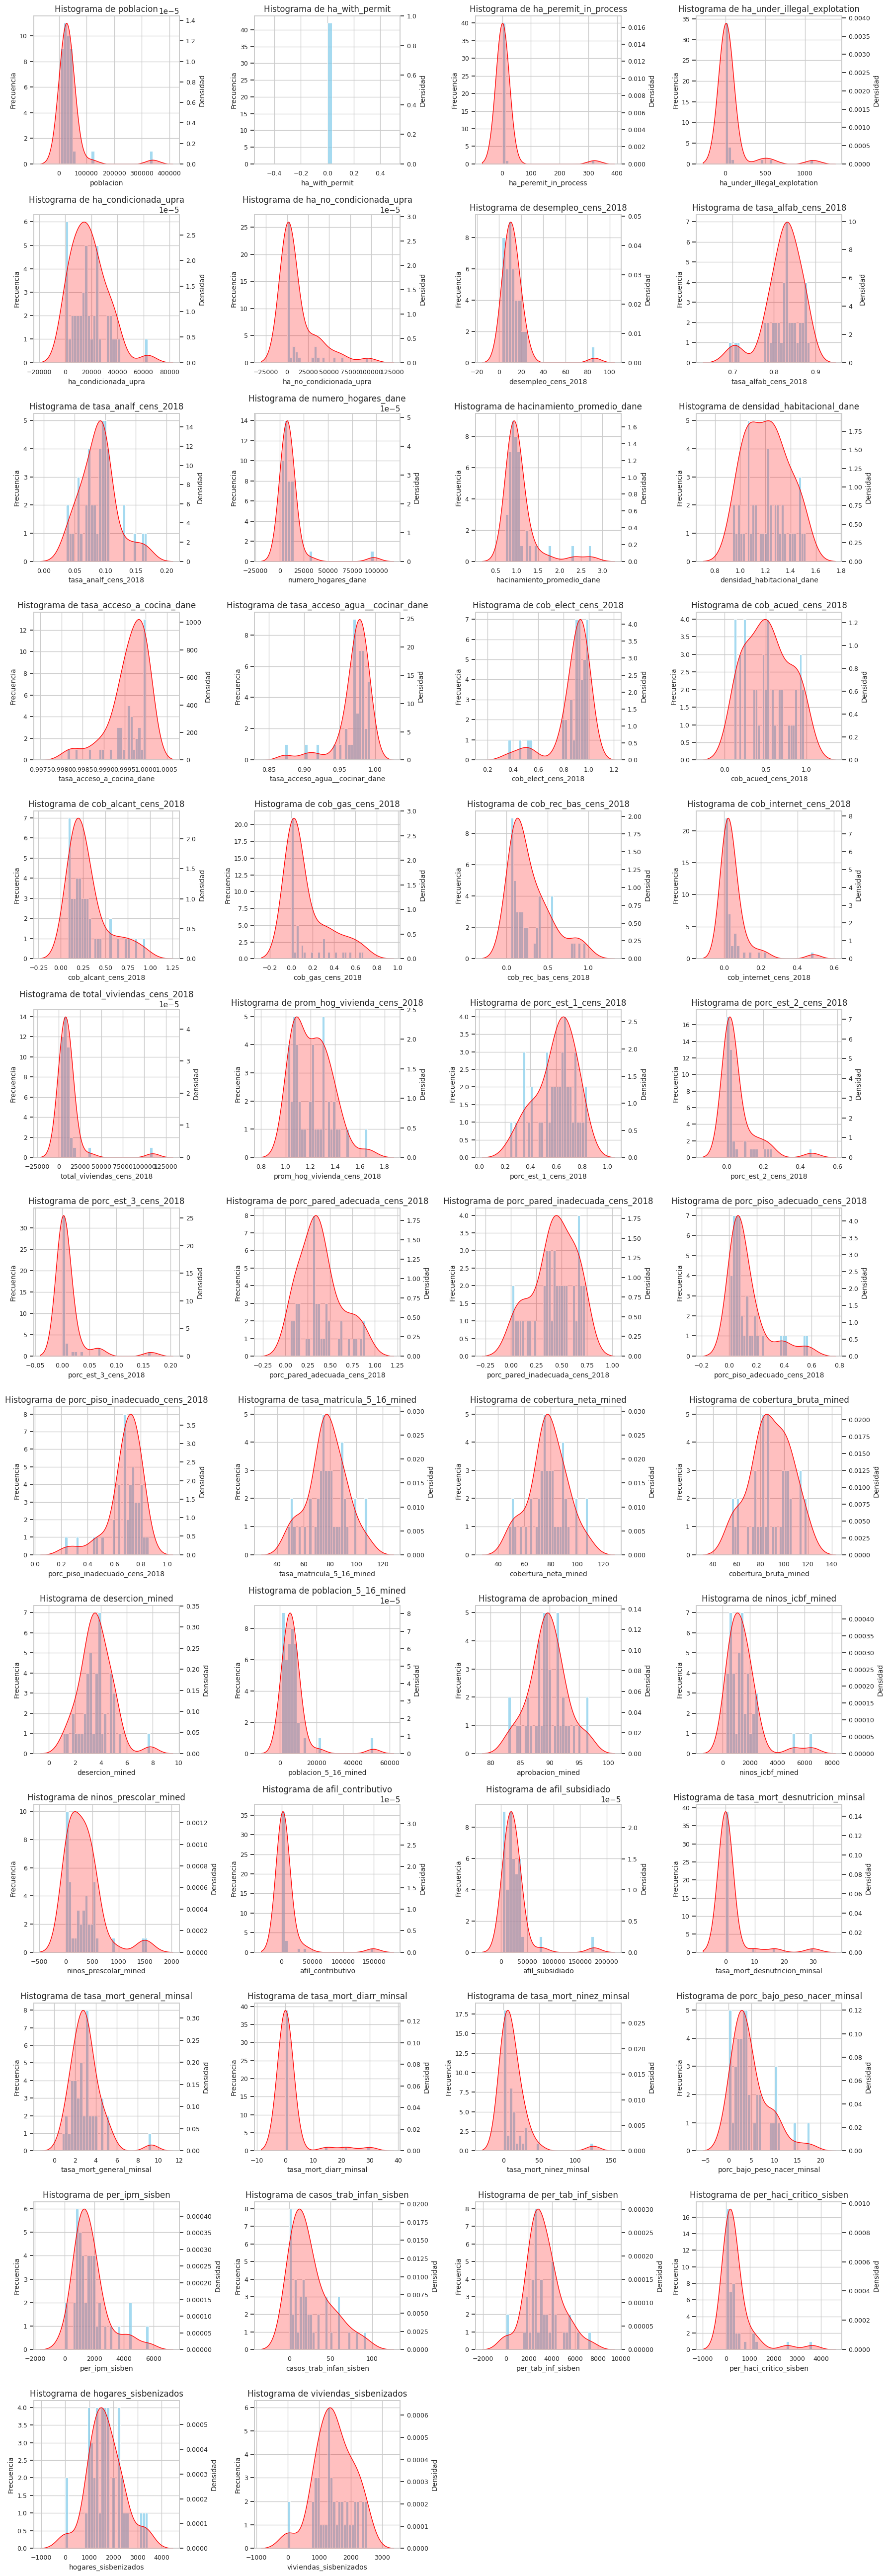

In [ ]:
# Llamar la función para todas las variables socioeconómicas
plot_distributions(df_var_socieconomicas, var_socieconomicas, save=True, filename='hist_densidad_var-sociec', format='png')

In [ ]:
df_var_socieconomicas[var_socieconomicas].describe()

poblacion  ha_with_permit  ha_peremit_in_process  \
count      42.000000            42.0              42.000000   
mean    37096.309524             0.0               8.365569   
std     51326.363660             0.0              49.452438   
min      5442.000000             0.0               0.000000   
25%     19188.250000             0.0               0.000000   
50%     27822.500000             0.0               0.000000   
75%     39261.250000             0.0               0.000000   
max    339454.000000             0.0             320.559333   

       ha_under_illegal_explotation  ha_condicionada_upra  \
count                     42.000000             42.000000   
mean                      58.474966          17965.352793   
std                      198.365506          13630.174939   
min                        0.000000            123.968017   
25%                        0.000000           7751.069669   
50%                        0.000000          15691.751394   
75%                        6.493179          24903.004211   
max                     1101.373169          63161.872514   

       ha_no_condicionada_upra  desempleo_cens_2018  tasa_alfab_cens_2018  \
count                42.000000            42.000000             42.000000   
mean              11718.735616            12.959936              0.822973   
std               21574.519982            12.752871              0.043850   
min                   0.000000             2.740426              0.690767   
25%                   0.000067             7.395307              0.804356   
50%                   3.583854            10.441034              0.830908   
75%               10277.017225            14.213098              0.848027   
max               95830.045100            86.257530              0.885963   

       tasa_analf_cens_2018  numero_hogares_dane  ...  \
count             42.000000            42.000000  ...   
mean               0.088808         10305.166667  ...   
std                0.029823         14599.365272  ...   
min                0.036354          1639.000000  ...   
25%                0.071883          5085.750000  ...   
50%                0.091182          7611.500000  ...   
75%                0.101668         10887.250000  ...   
max                0.168008         97164.000000  ...   

       tasa_mort_general_minsal  tasa_mort_diarr_minsal  \
count                 42.000000               42.000000   
mean                   3.029682                1.581403   
std                    1.455504                6.007825   
min                    0.753985                0.000000   
25%                    2.163080                0.000000   
50%                    2.969128                0.000000   
75%                    3.356224                0.000000   
max                    9.309414               29.868578   

       tasa_mort_ninez_minsal  porc_bajo_peso_nacer_minsal  per_ipm_sisben  \
count               42.000000                    42.000000       42.000000   
mean                12.628103                     4.611129     1702.952381   
std                 21.067756                     3.969339     1155.290608   
min                  0.000000                     0.000000        0.000000   
25%                  0.000000                     2.140745      960.750000   
50%                  9.901961                     3.250273     1530.000000   
75%                 14.772727                     6.279481     1964.750000   
max                125.000000                    17.647059     5659.000000   

       casos_trab_infan_sisben  per_tab_inf_sisben  per_haci_critico_sisben  \
count                42.000000           42.000000                42.000000   
mean                 24.642857         3217.761905               397.119048   
std                  23.711499         1454.546829               690.865777   
min                   0.000000            0.000000                 0.000000   
25%                   7.250000         2465.500000     

In [ ]:
# Definir el umbral de porcentaje de ceros para filtrar
threshold_percentage = 0.6

# Filtrar las columnas que son de tipo socioeconómico
df_socioeconomico = df_var_socieconomicas[var_socieconomicas]

# Calcular el porcentaje de ceros en cada columna
zero_percentage = (df_socioeconomico == 0).mean()

# Filtrar las columnas que tienen un porcentaje de ceros mayor al umbral
high_zero_columns = zero_percentage[zero_percentage > threshold_percentage].index

# Filtrar el DataFrame por esas columnas
df_high_zeros = df_socioeconomico[high_zero_columns]

# Aplicar describe() para ver las estadísticas de estas columnas
df_high_zeros.describe()

ha_with_permit  ha_peremit_in_process  ha_under_illegal_explotation  \
count            42.0              42.000000                     42.000000   
mean              0.0               8.365569                     58.474966   
std               0.0              49.452438                    198.365506   
min               0.0               0.000000                      0.000000   
25%               0.0               0.000000                      0.000000   
50%               0.0               0.000000                      0.000000   
75%               0.0               0.000000                      6.493179   
max               0.0             320.559333                   1101.373169   

       tasa_mort_desnutricion_minsal  tasa_mort_diarr_minsal  
count                      42.000000               42.000000  
mean                        1.346186                1.581403  
std                         5.401418                6.007825  
min                         0.000000                0.000000  
25%                         0.000000                0.000000  
50%                         0.000000                0.000000  
75%                         0.000000                0.000000  
max                        29.868578               29.868578

In [ ]:
# Función para generar diagramas de caja de un conjunto de variables
def plot_boxplots(df, columns, save=False, filename='plot', format='png'):
    # Número de gráficos por fila
    num_plots_per_row = 4

    # Ajuste del tamaño total de la figura
    total_plots = len(columns)
    num_rows = (total_plots // num_plots_per_row) + int(total_plots % num_plots_per_row > 0)

    # Ajuste de proporciones
    fig = plt.figure(figsize=(18, 4 * num_rows))

    # Iterar sobre las columnas y graficar en una cuadrícula de 4 por fila
    for i, col in enumerate(columns):
        plt.subplot(num_rows, num_plots_per_row, i + 1)

        # Crear el boxplot
        sns.boxplot(data=df, y=col, color='skyblue', linewidth=1.5, fliersize=5)

        # Ajustar títulos y etiquetas
        plt.title(f'Diagrama de Caja de {col}', fontsize=9, fontweight='bold')
        plt.ylabel(col, fontsize=10)
        plt.xticks([])  # Eliminar las etiquetas del eje X para mantener limpio el gráfico

        # Personalización adicional para mejorar la visualización
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)

    # Ajustar el espacio entre gráficos
    plt.tight_layout()

    # Guardar el gráfico si es necesario
    if save:
        save_plot(fig, filename, format, close_fig=False)

    plt.show()

In [ ]:
#  Columna que se detectaron con muchos nulos
del_col = ['ha_with_permit', 'ha_peremit_in_process',  'tasa_mort_desnutricion_minsal', 'tasa_mort_diarr_minsal']

# Eliminar de la lista de variables socioconomica
var_socieconomicas = [var for var in var_socieconomicas if var not in del_col]

# Eliminar Columnas del dataset
df_var_socieconomicas = df_var_socieconomicas.drop(del_col, axis=1)

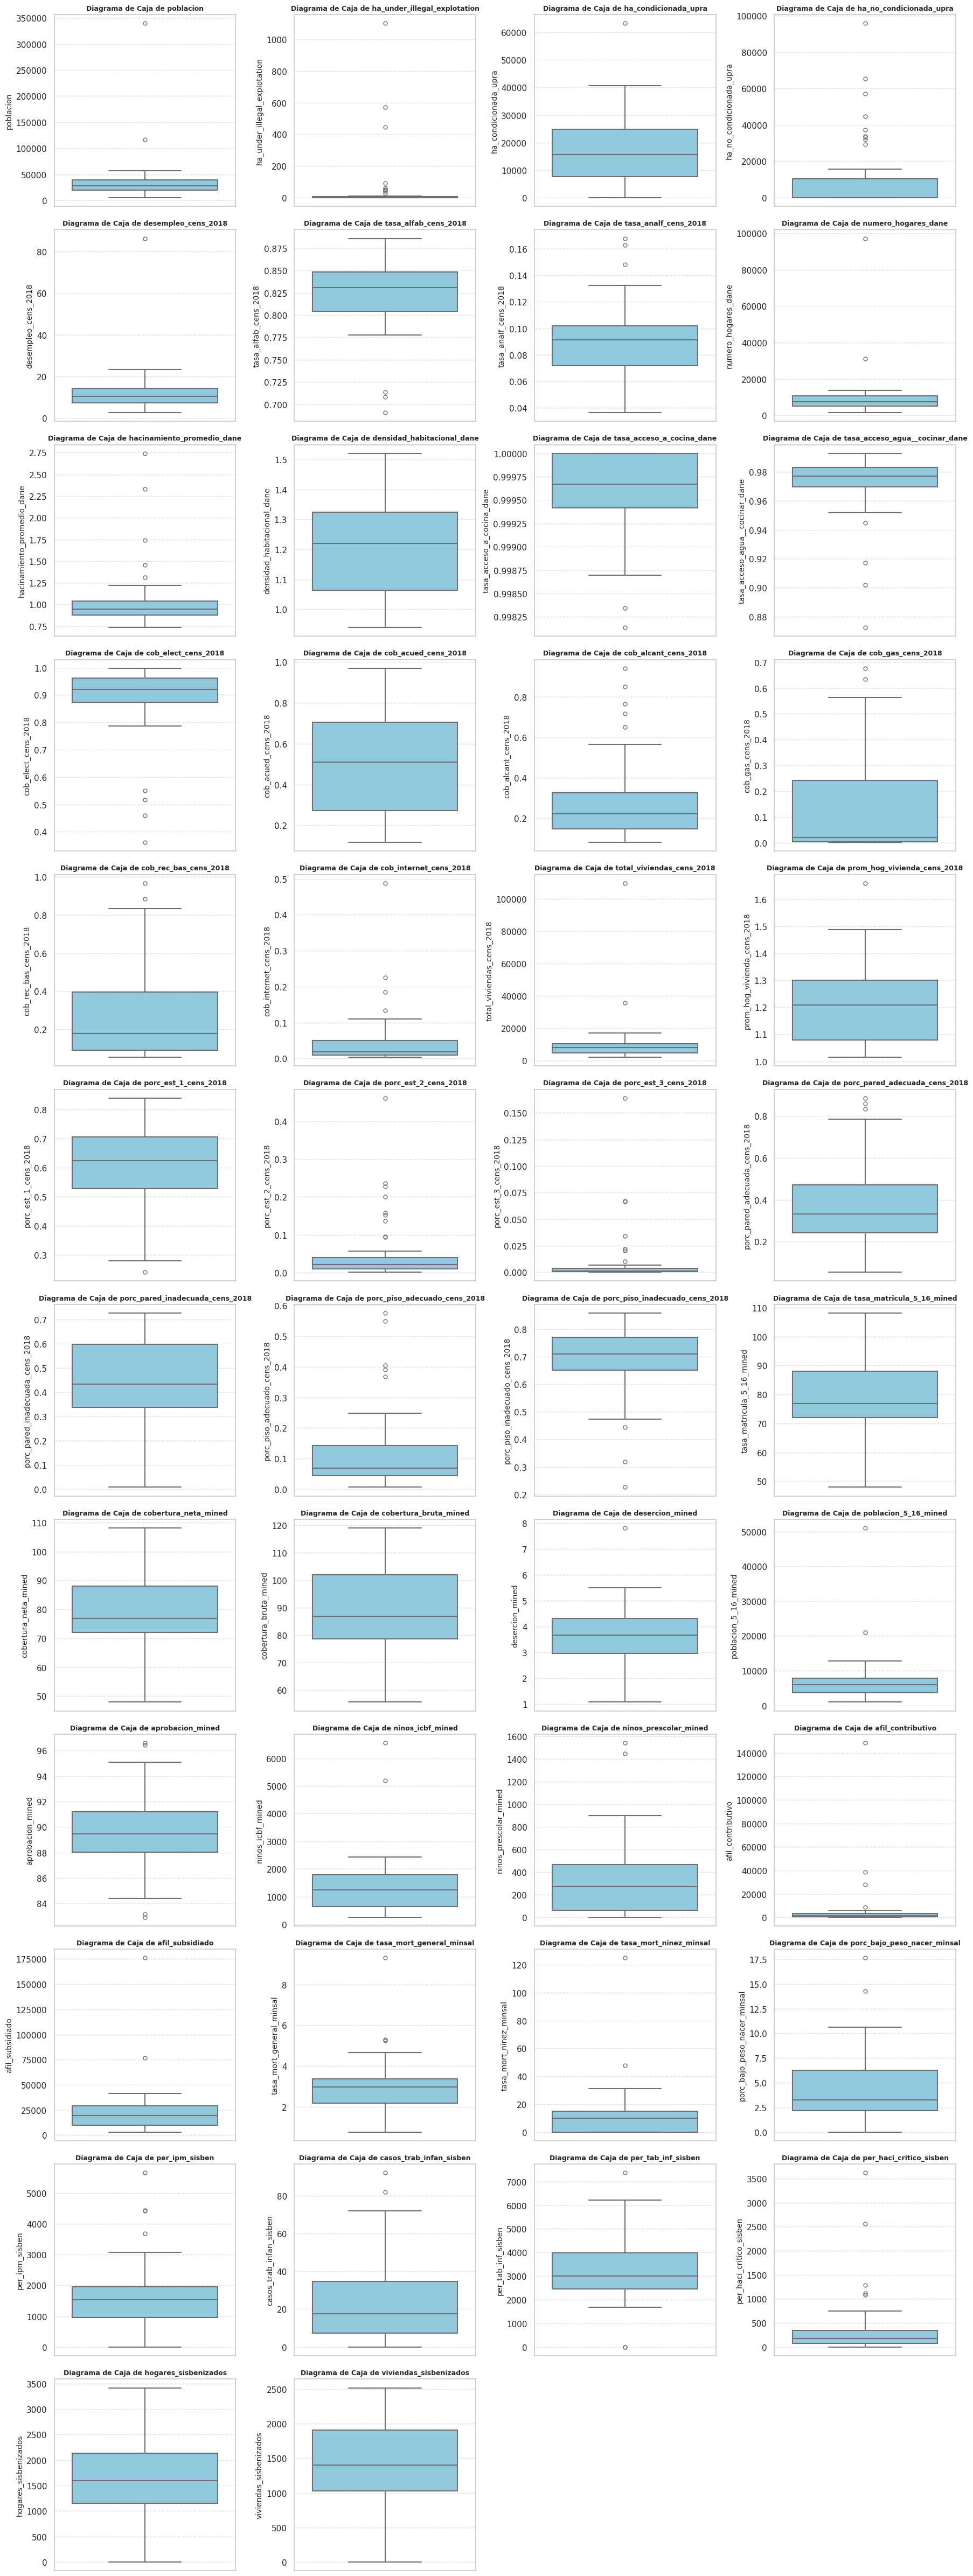

In [ ]:
# Uso:
plot_boxplots(df_var_socieconomicas, var_socieconomicas, save=True, filename='boxplot_var_sociec', format='png')

- Estudio de correlación entre variables socioeconómicas

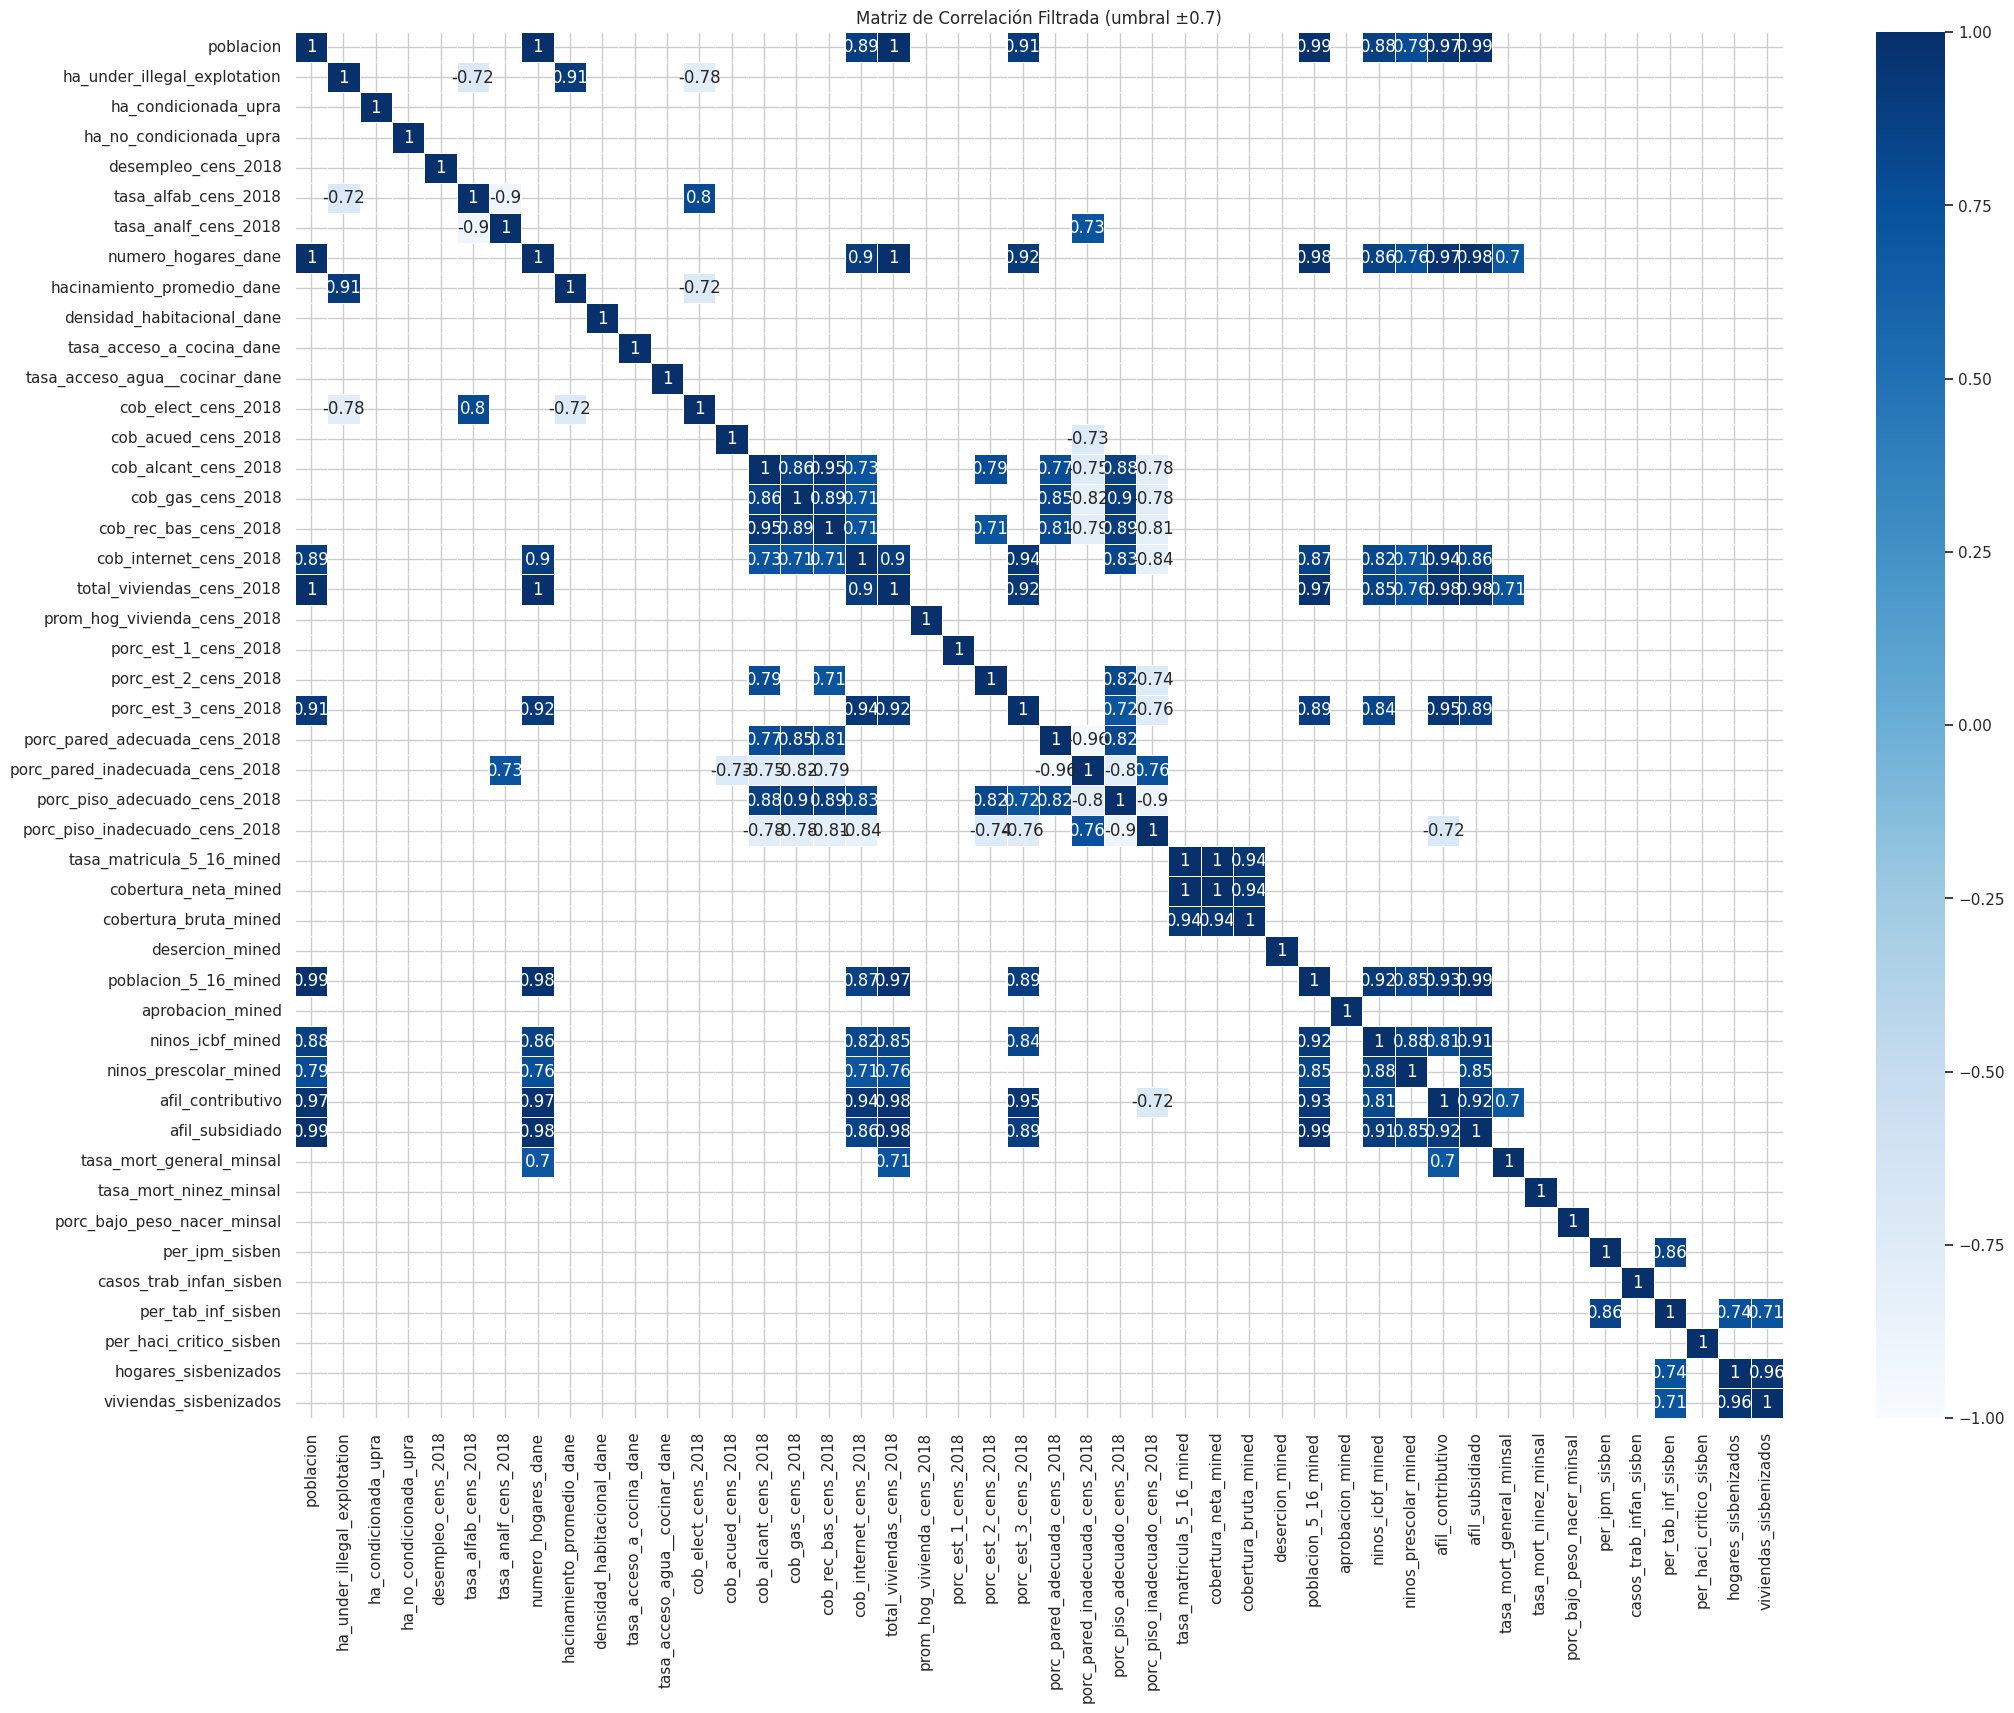

In [ ]:
# Extraer las columnas socioeconómicas del dataset
df_socieconomicas = df_var_socieconomicas[var_socieconomicas]

# Calcular la matriz de correlación usando el coeficiente de Pearson
matriz_correlacion = df_socieconomicas.corr(method='pearson')

# Filtrar la matriz de correlación para mostrar solo aquellas correlaciones superiores a 0.7 o inferiores a -0.7
high_corr_mask = (matriz_correlacion >= 0.7) | (matriz_correlacion <= -0.7)
high_corr_matrix = matriz_correlacion.where(high_corr_mask)

# Crear un mapa de calor solo para las correlaciones altas
fig = plt.figure(figsize=(24, 18))
sns.heatmap(high_corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1, linewidths=0.5, mask=high_corr_matrix.isnull())

plt.title("Matriz de Correlación Filtrada (umbral ±0.7)")

plt.show()

# Guardar el gráfico en un archivo de imagen
save_plot(fig, 'matriz_correlacion_filtrada', format='png', dpi=300)

In [ ]:
# Convertir la matriz de correlación en un formato de tabla (long-form)
correlation_pairs = matriz_correlacion.stack().reset_index()
correlation_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Filtrar las correlaciones que sean mayores o iguales a 0.7 o menores o iguales a -0.7
high_corr_pairs = correlation_pairs[(correlation_pairs['Correlación'] >= 0.7) | (correlation_pairs['Correlación'] <= -0.7)]

# Excluir las correlaciones entre una variable y sí misma
high_corr_pairs = high_corr_pairs[high_corr_pairs['Variable 1'] != high_corr_pairs['Variable 2']]

# Eliminar duplicados (pares inversos)
high_corr_pairs = high_corr_pairs.drop_duplicates(subset=['Correlación'])

# Ordenar por la magnitud de la correlación
high_corr_pairs = high_corr_pairs.sort_values(by='Correlación', ascending=False)

# Mostrar el resultado en formato tabular
high_corr_pairs

Variable 1                       Variable 2  \
1270      tasa_matricula_5_16_mined             cobertura_neta_mined   
340             numero_hogares_dane        total_viviendas_cens_2018   
7                         poblacion              numero_hogares_dane   
18                        poblacion        total_viviendas_cens_2018   
31                        poblacion             poblacion_5_16_mined   
...                             ...                              ...   
714               cob_gas_cens_2018  porc_pared_inadecuada_cens_2018   
808          cob_internet_cens_2018   porc_piso_inadecuado_cens_2018   
1176   porc_piso_adecuado_cens_2018   porc_piso_inadecuado_cens_2018   
236            tasa_alfab_cens_2018             tasa_analf_cens_2018   
1082  porc_pared_adecuada_cens_2018  porc_pared_inadecuada_cens_2018   

      Correlación  
1270     0.999999  
340      0.997812  
7        0.997454  
18       0.995763  
31       0.987708  
...           ...  
714     -0.823558  
808     -0.836662  
1176    -0.897670  
236     -0.902823  
1082    -0.964497  

[93 rows x 3 columns]

In [ ]:
high_corr_matrix

poblacion  ha_under_illegal_explotation  \
poblacion                         1.000000                           NaN   
ha_under_illegal_explotation           NaN                      1.000000   
ha_condicionada_upra                   NaN                           NaN   
ha_no_condicionada_upra                NaN                           NaN   
desempleo_cens_2018                    NaN                           NaN   
tasa_alfab_cens_2018                   NaN                     -0.715312   
tasa_analf_cens_2018                   NaN                           NaN   
numero_hogares_dane               0.997454                           NaN   
hacinamiento_promedio_dane             NaN                      0.911835   
densidad_habitacional_dane             NaN                           NaN   
tasa_acceso_a_cocina_dane              NaN                           NaN   
tasa_acceso_agua__cocinar_dane         NaN                           NaN   
cob_elect_cens_2018                    NaN                     -0.781636   
cob_acued_cens_2018                    NaN                           NaN   
cob_alcant_cens_2018                   NaN                           NaN   
cob_gas_cens_2018                      NaN                           NaN   
cob_rec_bas_cens_2018                  NaN                           NaN   
cob_internet_cens_2018            0.894140                           NaN   
total_viviendas_cens_2018         0.995763                           NaN   
prom_hog_vivienda_cens_2018            NaN                           NaN   
porc_est_1_cens_2018                   NaN                           NaN   
porc_est_2_cens_2018                   NaN                           NaN   
porc_est_3_cens_2018              0.914687                           NaN   
porc_pared_adecuada_cens_2018          NaN                           NaN   
porc_pared_inadecuada_cens_2018        NaN                           NaN   
porc_piso_adecuado_cens_2018           NaN                           NaN   
porc_piso_inadecuado_cens_2018         NaN                           NaN   
tasa_matricula_5_16_mined              NaN                           NaN   
cobertura_neta_mined                   NaN                           NaN   
cobertura_bruta_mined                  NaN                           NaN   
desercion_mined                        NaN                           NaN   
poblacion_5_16_mined              0.987708                           NaN   
aprobacion_mined                       NaN                           NaN   
ninos_icbf_mined                  0.876453                           NaN   
ninos_prescolar_mined             0.788687                           NaN   
afil_contributivo                 0.967007                           NaN   
afil_subsidiado                   0.985029                           NaN   
tasa_mort_general_minsal               NaN                           NaN   
tasa_mort_ninez_minsal                 NaN                           NaN   
porc_bajo_peso_nacer_minsal            NaN                           NaN   
per_ipm_sisben                         NaN                           NaN   
casos_trab_infan_sisben                NaN                           NaN   
per_tab_inf_sisben                     NaN                           NaN   
per_haci_critico_sisben                NaN                           NaN   
hogares_sisbenizados                   NaN                           NaN   
viviendas_sisbenizados                 NaN                           NaN   

                                 ha_condicionada_upra  \
poblacion                                         NaN   
ha_under_illegal_explotation                      NaN   
ha_condicionada_upra                              1.0   
ha_no_condicionada_upra                           NaN   
desempleo_cens_2018                               NaN   
tasa_alfab_cens_2018                              NaN   
tasa_analf_cens_2018                              NaN   
nume

- Acciones derivadas de analisis alta correlacion de variables

In [ ]:
# Crear el Índice Ponderado de Cobertura de Servicios Públicos Domiciliarios
# Asignación de los pesos a cada servicio público
peso_electricidad = 0.25
peso_agua = 0.25
peso_alcantarillado = 0.20
peso_gas = 0.10
peso_basura = 0.10
peso_internet = 0.10

# Creación de la nueva columna 'ind_cob_serv_pcos_dom' calculando el índice ponderado
df_var_socieconomicas['ind_cob_serv_pcos_dom'] = (
    peso_electricidad * df_var_socieconomicas['cob_elect_cens_2018'] +
    peso_agua * df_var_socieconomicas['cob_acued_cens_2018'] +
    peso_alcantarillado * df_var_socieconomicas['cob_alcant_cens_2018'] +
    peso_gas * df_var_socieconomicas['cob_gas_cens_2018'] +
    peso_basura * df_var_socieconomicas['cob_rec_bas_cens_2018'] +
    peso_internet * df_var_socieconomicas['cob_internet_cens_2018']
)

In [ ]:
# Fusion de variables

# Fusión de afil_subsidiado y afil_contributivo en afil_total_salud
df_var_socieconomicas['afil_total_salud'] = df_var_socieconomicas['afil_subsidiado'] + df_var_socieconomicas['afil_contributivo']

# Fusión de ninos_icbf_mined y ninos_prescolar_mined en atencion_inf_prescolar
df_var_socieconomicas['atencion_inf_prescolar'] = df_var_socieconomicas['ninos_icbf_mined'] + df_var_socieconomicas['ninos_prescolar_mined']

# Creación del índice de calidad del piso ind_cal_piso
df_var_socieconomicas['ind_cal_piso'] = df_var_socieconomicas['porc_piso_adecuado_cens_2018'] / (
    df_var_socieconomicas['porc_piso_adecuado_cens_2018'] + df_var_socieconomicas['porc_piso_inadecuado_cens_2018']
)

In [ ]:
var_to_delete = ['numero_hogares_dane', 'total_viviendas_cens_2018', 'porc_est_3_cens_2018', 'cobertura_bruta_mined', 'hogares_sisbenizados', 'per_tab_inf_sisben',
                 'porc_pared_inadecuada_cens_2018', 'porc_piso_inadecuado_cens_2018', 'tasa_analf_cens_2018', 'tasa_matricula_5_16_mined', 'cob_elect_cens_2018',
                 'cob_acued_cens_2018', 'cob_alcant_cens_2018', 'cob_gas_cens_2018', 'cob_rec_bas_cens_2018', 'cob_internet_cens_2018', 'afil_subsidiado',
                 'afil_contributivo', 'ninos_icbf_mined', 'ninos_prescolar_mined', 'porc_piso_adecuado_cens_2018', 'porc_piso_inadecuado_cens_2018', 'poblacion_5_16_mined']

In [ ]:
# Actualizar lista var_socieconomicas

# Eliminar de la lista de variables socioconomica
var_socieconomicas = [var for var in var_socieconomicas if var not in var_to_delete]

# incluir nuevas variables creadas
new_vars = ['afil_total_salud', 'atencion_inf_prescolar', 'ind_cal_piso', 'ind_cob_serv_pcos_dom']
var_socieconomicas = [var for var in var_socieconomicas if var not in var_to_delete]
var_socieconomicas = var_socieconomicas + new_vars

# Eliminar Columnas del dataset
df_var_socieconomicas = df_var_socieconomicas.drop(var_to_delete, axis=1)

In [ ]:
for i, name in enumerate(var_socieconomicas):
  print(f'indice {i}:  {name}')

indice 0:  poblacion
indice 1:  ha_under_illegal_explotation
indice 2:  ha_condicionada_upra
indice 3:  ha_no_condicionada_upra
indice 4:  desempleo_cens_2018
indice 5:  tasa_alfab_cens_2018
indice 6:  hacinamiento_promedio_dane
indice 7:  densidad_habitacional_dane
indice 8:  tasa_acceso_a_cocina_dane
indice 9:  tasa_acceso_agua__cocinar_dane
indice 10:  prom_hog_vivienda_cens_2018
indice 11:  porc_est_1_cens_2018
indice 12:  porc_est_2_cens_2018
indice 13:  porc_pared_adecuada_cens_2018
indice 14:  cobertura_neta_mined
indice 15:  desercion_mined
indice 16:  aprobacion_mined
indice 17:  tasa_mort_general_minsal
indice 18:  tasa_mort_ninez_minsal
indice 19:  porc_bajo_peso_nacer_minsal
indice 20:  per_ipm_sisben
indice 21:  casos_trab_infan_sisben
indice 22:  per_haci_critico_sisben
indice 23:  viviendas_sisbenizados
indice 24:  afil_total_salud
indice 25:  atencion_inf_prescolar
indice 26:  ind_cal_piso
indice 27:  ind_cob_serv_pcos_dom


In [ ]:
# Extraer las columnas socioeconómicas del dataset
df_socieconomicas = df_var_socieconomicas[var_socieconomicas]

# Calcular la matriz de correlación usando el coeficiente de Pearson
matriz_correlacion = df_socieconomicas.corr(method='pearson')

# Convertir la matriz de correlación en un formato de tabla (long-form)
correlation_pairs = matriz_correlacion.stack().reset_index()
correlation_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Filtrar las correlaciones que sean mayores o iguales a 0.7 o menores o iguales a -0.7
high_corr_pairs = correlation_pairs[(correlation_pairs['Correlación'] >= 0.7) | (correlation_pairs['Correlación'] <= -0.7)]

# Excluir las correlaciones entre una variable y sí misma
high_corr_pairs = high_corr_pairs[high_corr_pairs['Variable 1'] != high_corr_pairs['Variable 2']]

# Eliminar duplicados (pares inversos)
high_corr_pairs = high_corr_pairs.drop_duplicates(subset=['Correlación'])

# Ordenar por la magnitud de la correlación
high_corr_pairs = high_corr_pairs.sort_values(by='Correlación', ascending=False)

# Mostrar el resultado en formato tabular
high_corr_pairs

Variable 1                  Variable 2  Correlación
24                       poblacion            afil_total_salud     0.996368
34    ha_under_illegal_explotation  hacinamiento_promedio_dane     0.911835
697               afil_total_salud      atencion_inf_prescolar     0.875740
25                       poblacion      atencion_inf_prescolar     0.874972
391  porc_pared_adecuada_cens_2018       ind_cob_serv_pcos_dom     0.853892
755                   ind_cal_piso       ind_cob_serv_pcos_dom     0.840159
362           porc_est_2_cens_2018                ind_cal_piso     0.813958
390  porc_pared_adecuada_cens_2018                ind_cal_piso     0.807557
167           tasa_alfab_cens_2018       ind_cob_serv_pcos_dom     0.732937
363           porc_est_2_cens_2018       ind_cob_serv_pcos_dom     0.715707
33    ha_under_illegal_explotation        tasa_alfab_cens_2018    -0.715312

In [ ]:
df_var_socieconomicas[var_socieconomicas].info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 4 to 209
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   poblacion                       42 non-null     float64
 1   ha_under_illegal_explotation    42 non-null     float64
 2   ha_condicionada_upra            42 non-null     float64
 3   ha_no_condicionada_upra         42 non-null     float64
 4   desempleo_cens_2018             42 non-null     float64
 5   tasa_alfab_cens_2018            42 non-null     float64
 6   hacinamiento_promedio_dane      42 non-null     float64
 7   densidad_habitacional_dane      42 non-null     float64
 8   tasa_acceso_a_cocina_dane       42 non-null     float64
 9   tasa_acceso_agua__cocinar_dane  42 non-null     float64
 10  prom_hog_vivienda_cens_2018     42 non-null     float64
 11  porc_est_1_cens_2018            42 non-null     float64
 12  porc_est_2_cens_2018            42 non-nul

- Segundo ajuste derivado de altas correlaciones

In [ ]:
# Creación de la nueva variable de tasa de afiliación
df_var_socieconomicas['tasa_afiliacion_salud'] = df_var_socieconomicas['afil_total_salud'] / df_var_socieconomicas['poblacion']

# Selección de las columnas que serán fusionadas
cols_vivienda = ['porc_pared_adecuada_cens_2018', 'ind_cob_serv_pcos_dom', 'ind_cal_piso']

# Crear el índice compuesto como el promedio simple de las variables estandarizadas
df_var_socieconomicas['indice_condiciones_vivienda'] = df_var_socieconomicas[cols_vivienda].mean(axis=1)

In [ ]:
# Actualizar lista var_socieconomicas
var_to_delete = cols_vivienda + ['afil_total_salud']
# Eliminar de la lista de variables socioconomica
var_socieconomicas = [var for var in var_socieconomicas if var not in var_to_delete]

# incluir nuevas variables creadas
new_vars = ['tasa_afiliacion_salud', 'indice_condiciones_vivienda']
var_socieconomicas = [var for var in var_socieconomicas if var not in var_to_delete]
var_socieconomicas = var_socieconomicas + new_vars

# Eliminar Columnas del dataset
df_var_socieconomicas = df_var_socieconomicas.drop(var_to_delete, axis=1)

In [ ]:
print(len(var_socieconomicas))
len(df_var_socieconomicas.columns)

26


119

-  identificar la multicolinealidad entre las variables socioeconómicas que quedan con VIF - Factor de Inflación de la Varianza

In [ ]:
# Instalacion de bibliotecas para VIF
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Aplicar VIF
# Extraer solo las columnas socioeconómicas
X = df_var_socieconomicas[var_socieconomicas]

# Añadir una constante al modelo
X = sm.add_constant(X)

# Calcular el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Eliminar la fila correspondiente a la constante
vif_data = vif_data[vif_data["Variable"] != "const"]

# Ordenar el VIF de mayor a menor
vif_data = vif_data.sort_values(by="VIF", ascending=False)

# Mostrar el VIF para cada variable
print(vif_data)

                          Variable        VIF
7       hacinamiento_promedio_dane  28.848236
2     ha_under_illegal_explotation  27.569961
1                        poblacion  15.447699
26     indice_condiciones_vivienda  14.767771
24          atencion_inf_prescolar  13.887879
6             tasa_alfab_cens_2018  12.768679
13            porc_est_2_cens_2018  11.667544
23          viviendas_sisbenizados  10.228181
14            cobertura_neta_mined   9.739930
20                  per_ipm_sisben   8.602870
12            porc_est_1_cens_2018   8.440188
25           tasa_afiliacion_salud   8.181436
22         per_haci_critico_sisben   7.141483
16                aprobacion_mined   4.874000
17        tasa_mort_general_minsal   4.841941
21         casos_trab_infan_sisben   4.571345
9        tasa_acceso_a_cocina_dane   4.184704
11     prom_hog_vivienda_cens_2018   4.126722
8       densidad_habitacional_dane   3.724352
15                 desercion_mined   3.574193
3             ha_condicionada_upra

<ipython-input-130-58f3f72ce415>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x="VIF", y="Variable", data=df_vif, palette=palette, edgecolor="black")
<ipython-input-130-58f3f72ce415>:27: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  bar_plot = sns.barplot(x="VIF", y="Variable", data=df_vif, palette=palette, edgecolor="black")


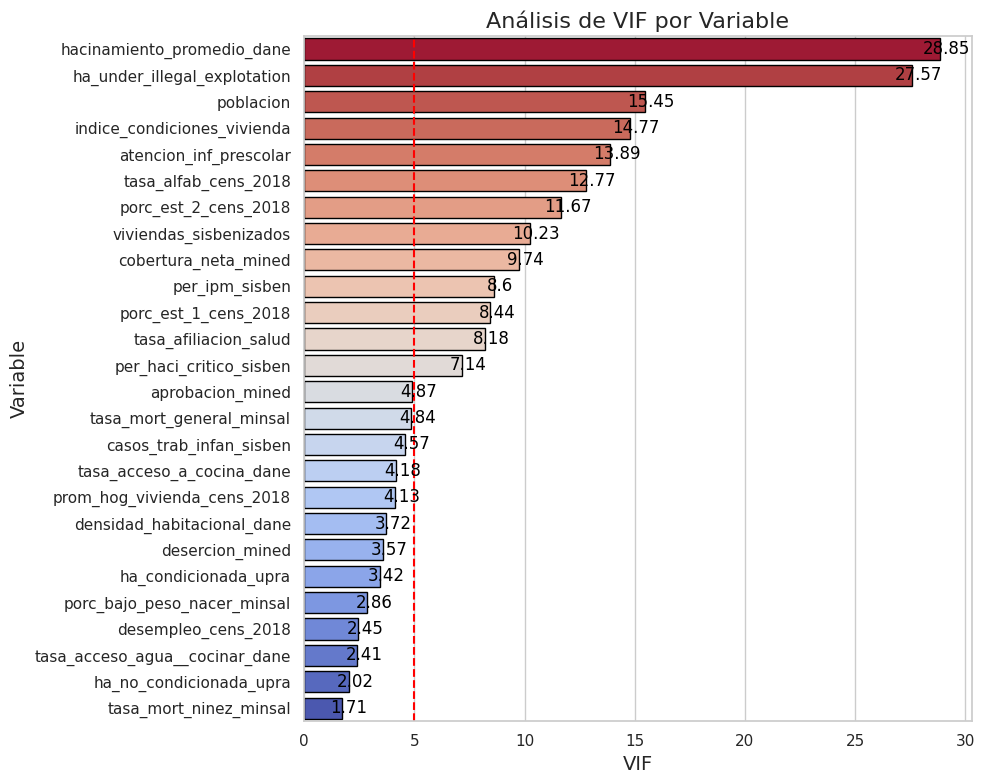

In [ ]:
# Grafica con datos de la tabla de VIF

data = {'Variable': ['hacinamiento_promedio_dane', 'ha_under_illegal_explotation', 'poblacion',
                     'indice_condiciones_vivienda', 'atencion_inf_prescolar', 'tasa_alfab_cens_2018',
                     'porc_est_2_cens_2018', 'viviendas_sisbenizados', 'cobertura_neta_mined',
                     'per_ipm_sisben', 'porc_est_1_cens_2018', 'tasa_afiliacion_salud',
                     'per_haci_critico_sisben', 'aprobacion_mined', 'tasa_mort_general_minsal',
                     'casos_trab_infan_sisben', 'tasa_acceso_a_cocina_dane', 'prom_hog_vivienda_cens_2018',
                     'densidad_habitacional_dane', 'desercion_mined', 'ha_condicionada_upra',
                     'porc_bajo_peso_nacer_minsal', 'desempleo_cens_2018', 'tasa_acceso_agua__cocinar_dane',
                     'ha_no_condicionada_upra', 'tasa_mort_ninez_minsal'],
        'VIF': [28.848236, 27.569961, 15.447699, 14.767771, 13.887879, 12.768679, 11.667544,
                10.228181, 9.739930, 8.602870, 8.440188, 8.181436, 7.141483, 4.874000,
                4.841941, 4.571345, 4.184704, 4.126722, 3.724352, 3.574193, 3.417139,
                2.864843, 2.447001, 2.405006, 2.018694, 1.710122]}

df_vif = pd.DataFrame(data)

# Configuración de estilo
sns.set(style="whitegrid")

# Invertir la paleta coolwarm
palette = sns.color_palette("coolwarm", as_cmap=True)(np.linspace(0, 1, len(df_vif)))[::-1]

# Crear la gráfica de barras horizontales
plt.figure(figsize=(10, 8))
bar_plot = sns.barplot(x="VIF", y="Variable", data=df_vif, palette=palette, edgecolor="black")

# Añadir la línea de referencia en VIF = 10
plt.axvline(x=5, color='red', linestyle='--', label='VIF = 5')

# Añadir las etiquetas de los valores de VIF en las barras
for i in range(len(df_vif)):
    bar_plot.text(df_vif.VIF[i] + 0.3, i, round(df_vif.VIF[i], 2), color='black', ha="center", va="center")

# Títulos y etiquetas
plt.title('Análisis de VIF por Variable', fontsize=16)
plt.xlabel('VIF', fontsize=14)
plt.ylabel('Variable', fontsize=14)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

- Implementar las deciones a partir del VIF

In [ ]:
# Actualizar lista var_socieconomicas
var_to_delete = ['hacinamiento_promedio_dane', 'tasa_acceso_agua__cocinar_dane', 'densidad_habitacional_dane', 'tasa_acceso_a_cocina_dane', 'prom_hog_vivienda_cens_2018', 'casos_trab_infan_sisben']
# Eliminar de la lista de variables socioconomica
var_socieconomicas = [var for var in var_socieconomicas if var not in var_to_delete]

# Eliminar Columnas del dataset
df_var_socieconomicas = df_var_socieconomicas.drop(var_to_delete, axis=1)

In [ ]:
print(len(var_socieconomicas))
len(df_var_socieconomicas.columns)

20


113

In [ ]:
# Aplicar VIF nuevamente
X = df_var_socieconomicas[var_socieconomicas]
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data[vif_data["Variable"] != "const"]
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data)

                        Variable        VIF
20   indice_condiciones_vivienda  12.108004
18        atencion_inf_prescolar  11.786351
1                      poblacion  10.857337
6           tasa_alfab_cens_2018   9.163933
17        viviendas_sisbenizados   8.941216
8           porc_est_2_cens_2018   8.001834
15                per_ipm_sisben   7.386931
19         tasa_afiliacion_salud   5.993253
9           cobertura_neta_mined   5.669347
2   ha_under_illegal_explotation   5.487263
16       per_haci_critico_sisben   4.209474
7           porc_est_1_cens_2018   3.699205
12      tasa_mort_general_minsal   3.614158
11              aprobacion_mined   3.419998
10               desercion_mined   3.048213
3           ha_condicionada_upra   2.974959
14   porc_bajo_peso_nacer_minsal   2.627862
4        ha_no_condicionada_upra   1.853980
5            desempleo_cens_2018   1.594362
13        tasa_mort_ninez_minsal   1.404730


- Aplicar informacion mutua

In [ ]:
# Definir las variables socioeconómicas
X = df_var_socieconomicas[var_socieconomicas]

# Calcular la información mutua entre las variables
mi_matrix = pd.DataFrame(np.zeros((X.shape[1], X.shape[1])), columns=var_socieconomicas, index=var_socieconomicas)

# Calcular la información mutua entre pares de variables
for i in range(X.shape[1]):
    for j in range(X.shape[1]):
        if i != j:
            # Información mutua entre la variable i y la j
            mi_matrix.iloc[i, j] = mutual_info_regression(X.iloc[:, [i]], X.iloc[:, j])[0]

# Abreviar los nombres de las columnas a los primeros 10 caracteres
#short_column_names = [col[:9] for col in mi_matrix.columns]

# Actualizar los nombres de las columnas en la matriz
#mi_matrix.columns = short_column_names

# Mostrar la matriz abreviada
mi_matrix

poblacion  ha_under_illegal_explotation  \
poblacion                      0.000000                      0.000000   
ha_under_illegal_explotation   0.000000                      0.000000   
ha_condicionada_upra           0.096297                      0.017407   
ha_no_condicionada_upra        0.060372                      0.089284   
desempleo_cens_2018            0.053054                      0.000000   
tasa_alfab_cens_2018           0.050421                      0.018952   
porc_est_1_cens_2018           0.034975                      0.000000   
porc_est_2_cens_2018           0.003664                      0.030798   
cobertura_neta_mined           0.020750                      0.015761   
desercion_mined                0.000000                      0.035698   
aprobacion_mined               0.119062                      0.063238   
tasa_mort_general_minsal       0.000000                      0.029942   
tasa_mort_ninez_minsal         0.196923                      0.080048   
porc_bajo_peso_nacer_minsal    0.132281                      0.000000   
per_ipm_sisben                 0.000000                      0.000000   
per_haci_critico_sisben        0.000000                      0.015717   
viviendas_sisbenizados         0.052202                      0.000000   
atencion_inf_prescolar         0.757031                      0.000000   
tasa_afiliacion_salud          0.089967                      0.000000   
indice_condiciones_vivienda    0.000000                      0.045258   

                              ha_condicionada_upra  ha_no_condicionada_upra  \
poblacion                                 0.096297                 0.060372   
ha_under_illegal_explotation              0.010200                 0.116678   
ha_condicionada_upra                      0.000000                 0.395147   
ha_no_condicionada_upra                   0.395147                 0.000000   
desempleo_cens_2018                       0.000000                 0.103955   
tasa_alfab_cens_2018                      0.066691                 0.000000   
porc_est_1_cens_2018                      0.000000                 0.000000   
porc_est_2_cens_2018                      0.027474                 0.000000   
cobertura_neta_mined                      0.087491                 0.016185   
desercion_mined                           0.000000                 0.051722   
aprobacion_mined                          0.035897                 0.000000   
tasa_mort_general_minsal                  0.149431                 0.046363   
tasa_mort_ninez_minsal                    0.113397                 0.097358   
porc_bajo_peso_nacer_minsal               0.000000                 0.077766   
per_ipm_sisben                            0.000000                 0.032397   
per_haci_critico_sisben                   0.279392                 0.115866   
viviendas_sisbenizados                    0.226599                 0.027138   
atencion_inf_prescolar                    0.025608                 0.049539   
tasa_afiliacion_salud                     0.000000                 0.032405   
indice_condiciones_vivienda               0.041073                 0.116626   

                              desempleo_cens_2018  tasa_alfab_cens_2018  \
poblacion                                0.055699              0.050421   
ha_under_illegal_explotation             0.000000              0.031237   
ha_condicionada_upra                     0.000000              0.066691   
ha_no_condicionada_upra                  0.103955              0.000000   
desempleo_cens_2018                      0.000000              0.285075   
tasa_alfab_cens_2018                     0.285075              0.000000   
porc_est_1_cens_2018                     0.042187              0.056717   
porc_est_2_cens_2018                     0.035724              0.122204   
cobertura_neta_mined                     0.103941              0.022682   
desercion_mined                          0.041630              0.060263   
aprobacion_

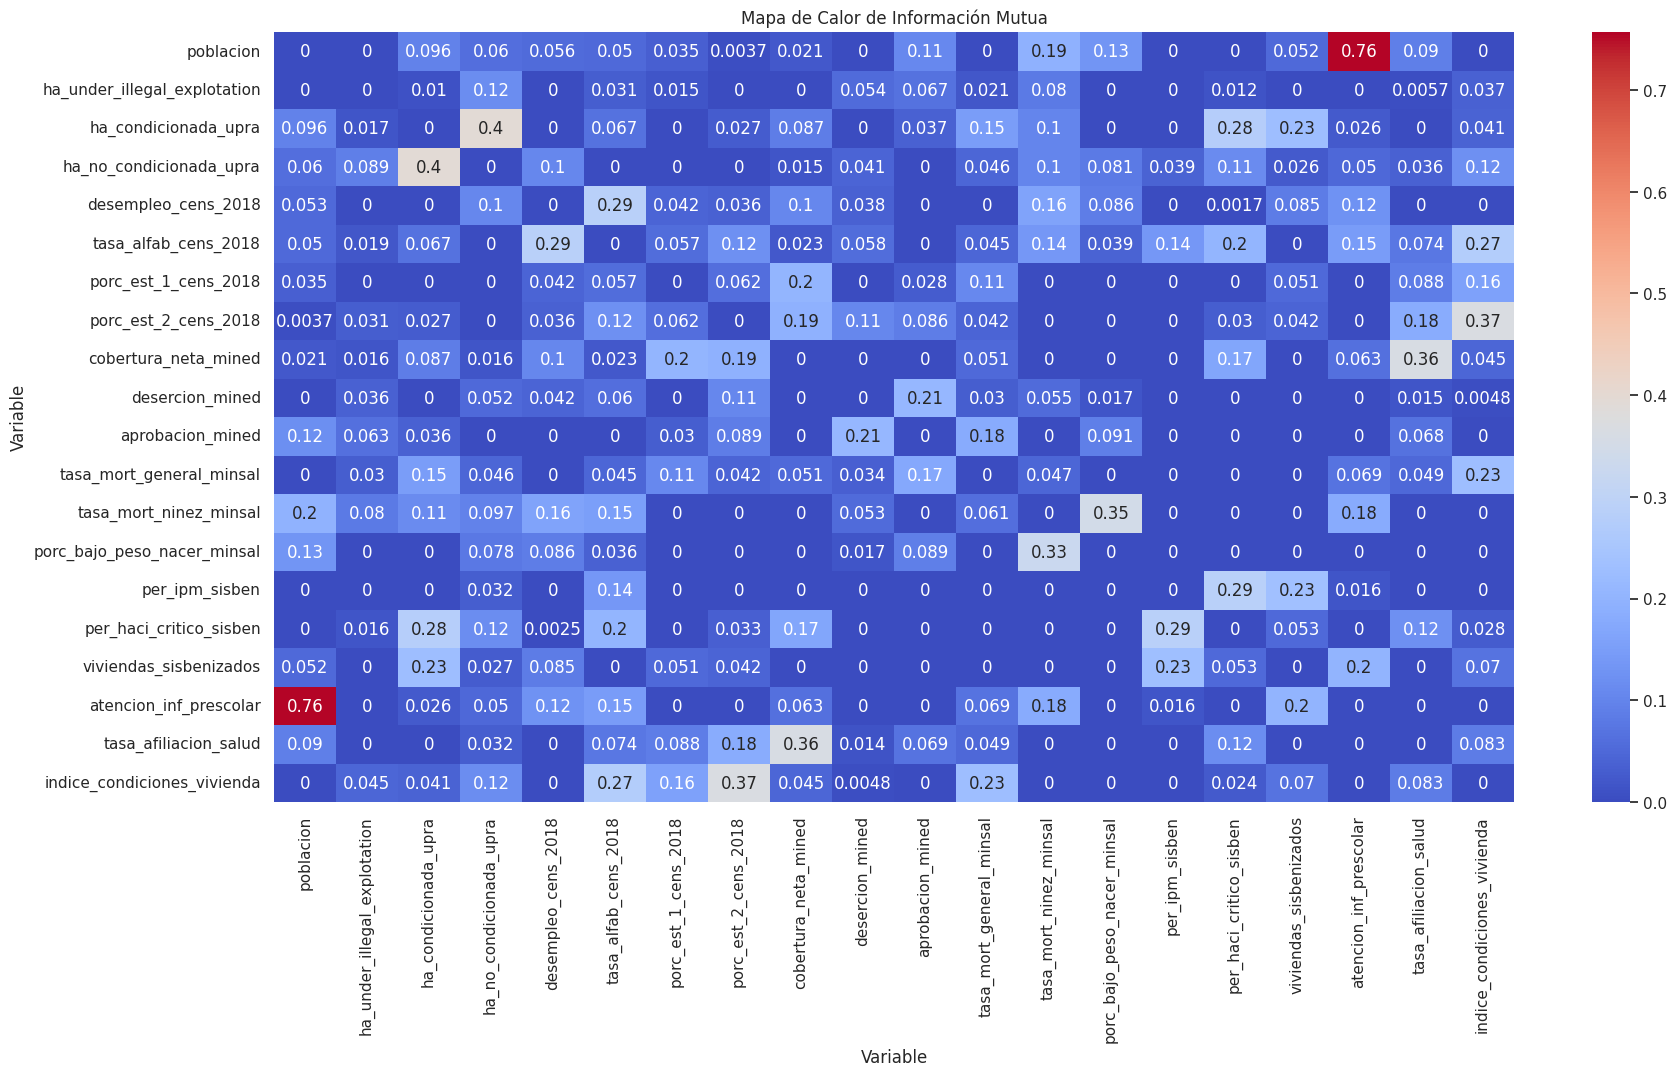

In [ ]:
# Crear un mapa de calor
# Abreviar los nombres de las columnas a los primeros 10 caracteres
column_names = [col for col in mi_matrix.columns]


plt.figure(figsize=(20, 10))
sns.heatmap(mi_matrix, annot=True, cmap='coolwarm')

# Personalizar el gráfico (opcional)
plt.title('Mapa de Calor de Información Mutua')
plt.xlabel('Variable')
plt.ylabel('Variable')

# Mostrar el gráfico
plt.show()

- Implentar la La importancia de la permutación

In [ ]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

# Solo variables socioeconómicas
X = df_var_socieconomicas[var_socieconomicas]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-Means para obtener etiquetas artificiales
kmeans = KMeans(n_clusters=5, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

# Entrenar un modelo supervisado LogisticRegression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_scaled, y_kmeans)

# Aplicar la importancia de la permutación
result = permutation_importance(log_reg, X_scaled, y_kmeans, n_repeats=10, random_state=42, n_jobs=-1)

# Obtener las importancias y ordenar
sorted_indices = result.importances_mean.argsort()[::-1]

# Mostrar los resultados ordenados
for idx in sorted_indices:
    print(f'{var_socieconomicas[idx]}: {result.importances_mean[idx]:.3f}')

ha_condicionada_upra: 0.076
porc_est_2_cens_2018: 0.074
aprobacion_mined: 0.074
viviendas_sisbenizados: 0.048
desercion_mined: 0.038
per_haci_critico_sisben: 0.036
ha_under_illegal_explotation: 0.026
tasa_afiliacion_salud: 0.026
ha_no_condicionada_upra: 0.017
atencion_inf_prescolar: 0.005
tasa_mort_ninez_minsal: 0.005
tasa_alfab_cens_2018: 0.000
desempleo_cens_2018: 0.000
indice_condiciones_vivienda: 0.000
porc_est_1_cens_2018: 0.000
cobertura_neta_mined: 0.000
tasa_mort_general_minsal: 0.000
porc_bajo_peso_nacer_minsal: 0.000
per_ipm_sisben: 0.000
poblacion: 0.000


- Aplicar la importancia de las caracteristica de random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar un Random Forest con las etiquetas de cluster como objetivo
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y_kmeans)

# Obtener la importancia de las características de Random Forest
importances = rf.feature_importances_
sorted_indices = importances.argsort()[::-1]

# Mostrar los resultados ordenados
for idx in sorted_indices:
    print(f'{var_socieconomicas[idx]}: {importances[idx]:.3f}')

ha_condicionada_upra: 0.098
aprobacion_mined: 0.096
porc_est_2_cens_2018: 0.090
viviendas_sisbenizados: 0.087
tasa_mort_general_minsal: 0.071
desercion_mined: 0.068
indice_condiciones_vivienda: 0.052
porc_est_1_cens_2018: 0.050
tasa_afiliacion_salud: 0.050
tasa_alfab_cens_2018: 0.049
per_haci_critico_sisben: 0.047
per_ipm_sisben: 0.044
cobertura_neta_mined: 0.039
atencion_inf_prescolar: 0.032
porc_bajo_peso_nacer_minsal: 0.030
ha_no_condicionada_upra: 0.023
desempleo_cens_2018: 0.022
poblacion: 0.020
tasa_mort_ninez_minsal: 0.018
ha_under_illegal_explotation: 0.018


### Visualizar en mapas las variables que quedaron

In [ ]:
import geopandas as gpd
from shapely import wkb
from shapely.geometry import Point

# Convertir a un GeoDataFrame
geo_socieconomica = gpd.GeoDataFrame(df_var_socieconomicas, geometry=gpd.GeoSeries.from_wkb(df_var_socieconomicas['geometria_mpio']))

In [ ]:
# Convertir las cabeceras municipales en geometrías de puntos
geo_socieconomica['geometria_cabecera'] = gpd.GeoSeries.from_wkb(geo_socieconomica['geometria_cabecera'])

In [ ]:
#Definir el sistema de referencia de coordenadas (CRS)
geo_socieconomica = geo_socieconomica.set_crs(epsg=4326, inplace=True)

In [ ]:
# Función para calcular la distancia entre puntos
def check_proximity(current_point, other_points, threshold=0.1):
    for other_point in other_points:
        if current_point.distance(other_point) < threshold:
            return True
    return False

In [ ]:
# Definir la función para graficar cualquier variable del DataFrame georreferenciado
def plot_variable(df, variable, cmap='Reds', color_point='blue', title_prefix='Departamento del Cauca - ', threshold_distance=0.1):
    """
    Grafica una variable específica en un mapa del departamento del Cauca.

    Parámetros:
    - df: GeoDataFrame con las geometrías y variables a graficar.
    - variable: str, nombre de la variable en el GeoDataFrame a graficar.
    - cmap: str, color del mapa. Por defecto 'Reds'.
    - color_point: str, color de los puntos de cabeceras municipales. Por defecto 'blue'.
    - title_prefix: str, prefijo del título del mapa. Por defecto 'Departamento del Cauca - '.
    - threshold_distance: float, distancia de umbral para ajustar etiquetas cercanas. Por defecto 0.1.

    Retorna:
    - fig, ax: figura y eje del gráfico para permitir su manipulación o guardado.
    """

    # Verificar si la variable existe en el DataFrame
    if variable not in df.columns:
        print(f"La variable '{variable}' no existe en el DataFrame.")
        return None, None

    # Crear lista para almacenar posiciones ya asignadas
    assigned_positions = []

    # Crear la figura y el eje
    fig, ax = plt.subplots(figsize=(15, 9))

    # Crear el mapa base
    df.plot(column=variable, cmap=cmap, legend=True, ax=ax,
            vmin=df[variable].min(), vmax=df[variable].max() - (df[variable].max() * 0.1),
            edgecolor='gray', linewidth=0.25)

    # Título del mapa
    ax.set_title(f'{title_prefix} {variable}', fontsize=16)

    # Colocar los nombres de los municipios
    for idx, row in df.iterrows():
        current_point = row['geometria_cabecera']

        # Verificar si el punto está cerca de otro ya asignado
        if check_proximity(current_point, assigned_positions, threshold_distance):
            x_offset, y_offset = 0.015, 0.015
            ha, va = 'left', 'bottom'
        else:
            x_offset, y_offset = 0, 0
            ha, va = 'right', 'top'

        # Colocar el texto de cada municipio
        ax.text(row['geometria_cabecera'].x + x_offset, row['geometria_cabecera'].y + y_offset,
                row['nombre_municipio'],
                fontsize=5, ha=ha, va=va, color='black')

        # Almacenar la posición asignada para verificar superposiciones
        assigned_positions.append(Point(row['geometria_cabecera'].x, row['geometria_cabecera'].y))

    # Graficar los puntos de las cabeceras municipales encima del mapa base
    df.set_geometry('geometria_cabecera').plot(ax=ax, color=color_point, markersize=7, zorder=5)

    # Ocultar ejes
    ax.axis('off')

    # Retornar la figura y el eje
    return fig, ax

In [ ]:
# Uso
fig, ax = plot_variable(geo_socieconomica, 'indice_condiciones_vivienda')
if fig:
    save_plot(fig, "mapa_indice_condiciones_vivienda")

In [ ]:
var_socieconomicas

['poblacion',
 'ha_under_illegal_explotation',
 'ha_condicionada_upra',
 'ha_no_condicionada_upra',
 'desempleo_cens_2018',
 'tasa_alfab_cens_2018',
 'porc_est_1_cens_2018',
 'porc_est_2_cens_2018',
 'cobertura_neta_mined',
 'desercion_mined',
 'aprobacion_mined',
 'tasa_mort_general_minsal',
 'tasa_mort_ninez_minsal',
 'porc_bajo_peso_nacer_minsal',
 'per_ipm_sisben',
 'per_haci_critico_sisben',
 'viviendas_sisbenizados',
 'atencion_inf_prescolar',
 'tasa_afiliacion_salud',
 'indice_condiciones_vivienda']

## Análisis variables relacionadas con hechos de violencia

- Revisión de distribuciones

In [ ]:
# Variables violencia tras la depuracion inicial
var_violencia = [
    'kls_basuco_incaut_mindef', 'ha_coca_cultivada_minjust', 'kls_coca_confis_mindef', 'kls_base_coca_confis_mindef', 'cantidad_mariguana_confiscada',
    'amenazas_casos_fiscalia','delitos_sexuales_casos_fiscalia', 'desaparicion_forzada_casos_fiscalia', 'desplazamiento_casos_fiscalia', 'estafa_casos_fiscalia',
    'extorsion_casos_fiscalia', 'hurto_casos_fiscalia', 'personas_bienes_dih_casos_fiscalia', 'reclutamiento_ilicito_casos_fiscalia',
    'violencia_intrafamiliar_casos_fiscalia', 'corrupcion_casos_fiscalia', 'homicidios_casos_fiscalia', 'lesiones_personales_casos_fiscalia',
    'secuestro_casos_fiscalia', 'otros_delitos_casos_fiscalia', 'vict_fuerza_pub_mindef', 'armas_confis_polinal', 'total_reclam_rest_tierr_minagr',
    'vict_por_declarac_uv'
]

Nota: El análisis de las 24 variables que quedaron tras la depuración inicial se abordará sumando las variables de ocurrencia de delitos y las relacionadas con incautación de narcotráfico para el periodo 2019-2023, con el fin de equilibrar la representatividad temporal frente a aquellas variables que corresponden a reportes "con corte a", como 'vict_por_declarac_uv', 'ha_coca_cultivada_minjust' y 'total_reclam_rest_tierr_minagr', que ya acumulan información de varios años. Este enfoque permitirá comparar fenómenos de diferentes duraciones temporales de manera más coherente y facilitará un análisis más balanceado de los datos, asegurando que los eventos de corta duración no se subestimen frente a aquellos que abarcan periodos más largos.

In [ ]:
# Separar las variables que tienen 'corte a'
vars_2023 = ['vict_por_declarac_uv', 'ha_coca_cultivada_minjust', 'total_reclam_rest_tierr_minagr']
vars_sum = [col for col in var_violencia if col not in vars_2023]

# Filtrar el DataFrame por las columnas de interés
df_var_violencia_2023 = df_final[df_final['anio'] == 2023][['codigo_dane', *vars_2023]]
df_var_violencia_sum = df_final[['codigo_dane', *vars_sum]]

# Agrupar y sumar las variables que deben tener la suma de todos los años
df_var_violencia_sum = df_var_violencia_sum.groupby('codigo_dane').sum().reset_index()

# Tomar los valores del año 2023 para las variables especificadas
df_var_violencia_2023 = df_var_violencia_2023.groupby('codigo_dane').first().reset_index()

# Unir ambos DataFrames en un solo DataFrame final
df_var_violencia = df_var_violencia_sum.merge(df_var_violencia_2023, on='codigo_dane', how='left')

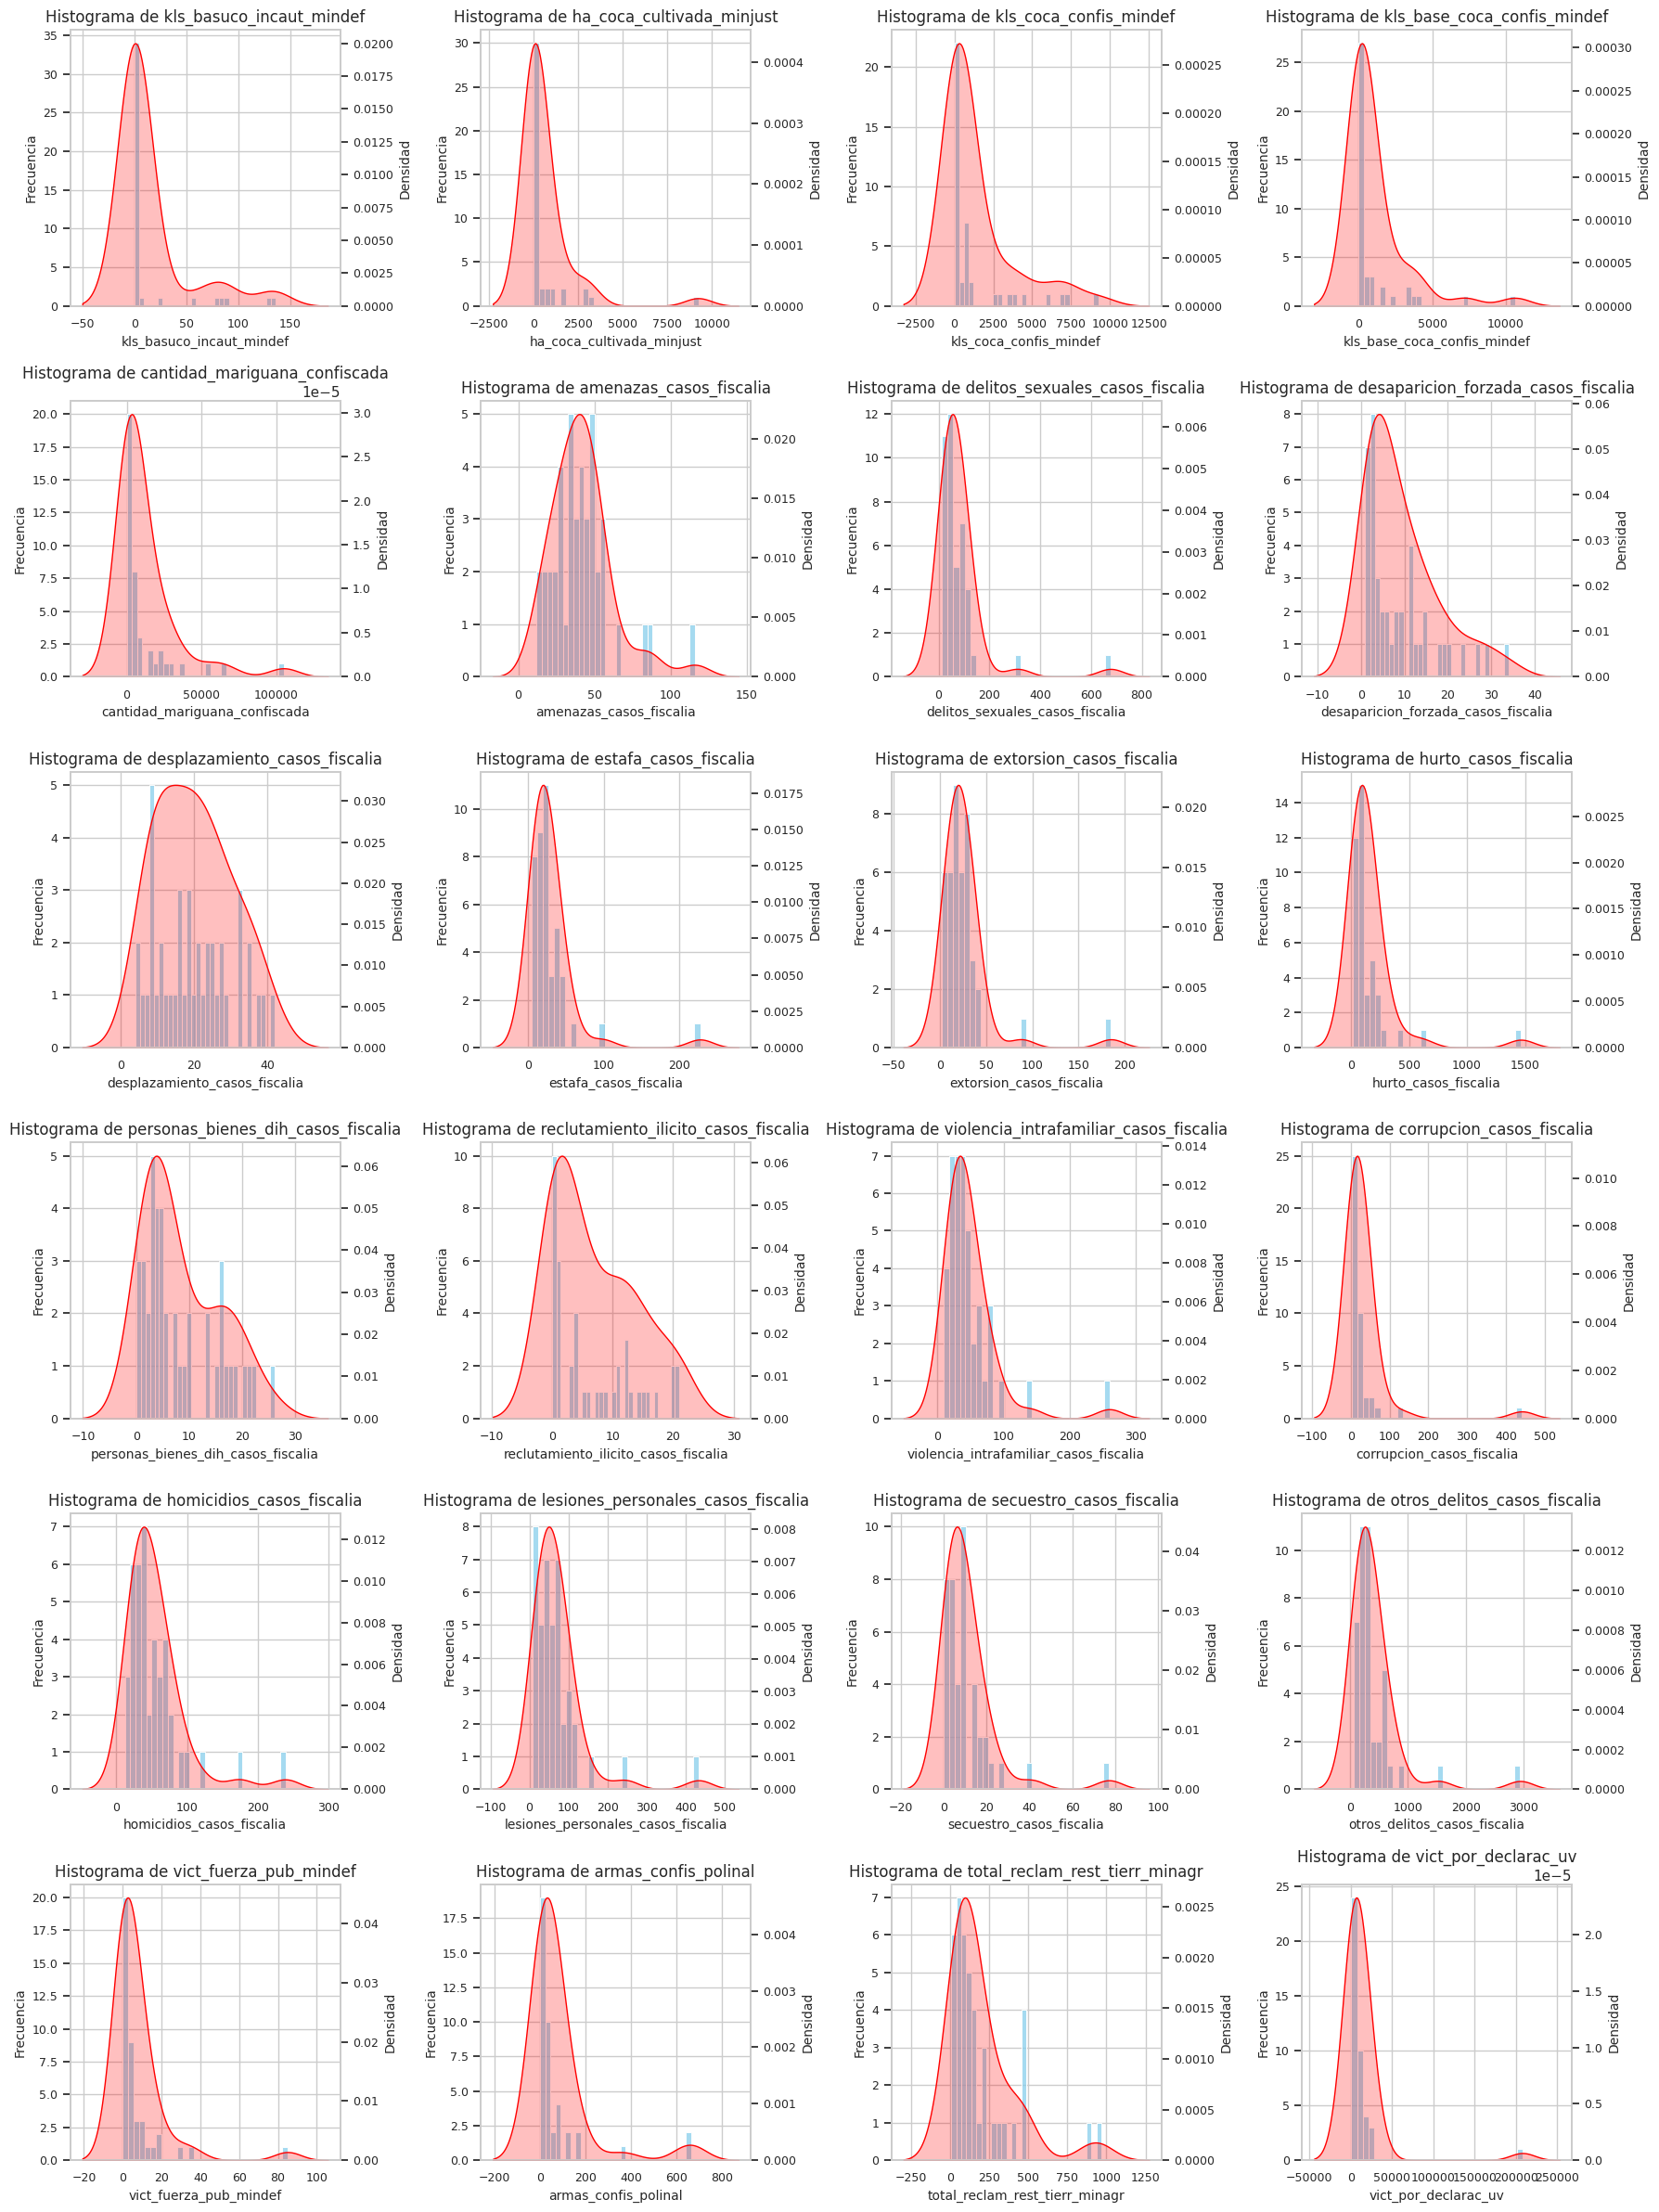

In [ ]:
# Llamar función que grafica histogramas y gráficos de densidad - variables violencia
plot_distributions(df_var_violencia, var_violencia, save=True, filename='hist_densidad_var_violencia', format='png')

In [ ]:
df_var_violencia[var_violencia].describe()

kls_basuco_incaut_mindef  ha_coca_cultivada_minjust  \
count                 42.000000                  42.000000   
mean                  14.637590                 624.023810   
std                   35.332399                1586.666232   
min                    0.000000                   0.000000   
25%                    0.000000                   0.000000   
50%                    0.000000                  12.000000   
75%                    1.451575                 465.250000   
max                  136.428000                9223.000000   

       kls_coca_confis_mindef  kls_base_coca_confis_mindef  \
count               42.000000                    42.000000   
mean              1357.328335                  1053.340375   
std               2298.809624                  2140.138410   
min                  0.000000                     0.000000   
25%                  5.701750                     2.967500   
50%                298.094000                    72.406000   
75%               1033.912150                   884.686000   
max               9241.409000                 10614.882000   

       cantidad_mariguana_confiscada  amenazas_casos_fiscalia  \
count                      42.000000                42.000000   
mean                    11972.118558                41.619048   
std                     20877.541388                20.113037   
min                         0.000000                12.000000   
25%                       873.102250                28.250000   
50%                      3736.353000                40.000000   
75%                     14460.234500                49.000000   
max                    105031.297000               116.000000   

       delitos_sexuales_casos_fiscalia  desaparicion_forzada_casos_fiscalia  \
count                        42.000000                            42.000000   
mean                         79.500000                             9.071429   
std                         106.878835                             8.303372   
min                          14.000000                             1.000000   
25%                          34.000000                             3.000000   
50%                          54.000000                             6.000000   
75%                          88.250000                            12.500000   
max                         677.000000                            34.000000   

       desplazamiento_casos_fiscalia  estafa_casos_fiscalia  ...  \
count                      42.000000              42.000000  ...   
mean                       19.857143              28.595238  ...   
std                        10.254259              35.886039  ...   
min                         4.000000               4.000000  ...   
25%                        11.000000              12.250000  ...   
50%                        19.000000              21.000000  ...   
75%                        26.750000              33.500000  ...   
max                        42.000000             228.000000  ...   

       violencia_intrafamiliar_casos_fiscalia  corrupcion_casos_fiscalia  \
count                               42.000000                  42.000000   
mean                                47.880952                  30.880952   
std                                 42.243315                  68.366017   
min                                  9.000000                   3.000000   
25%                                 25.500000                  10.000000   
50%                                 38.500000                  15.500000   
75%                                 57.250000                  21.750000   
max                                260.000000                 441.000000   

       homicidios_casos_fiscalia  lesiones_personales_casos_fiscalia  \
count                  42.000000                           42.000000   
mean                   54.333333                           70.333333   
std                    42.342775                           72.067606   
min  

In [ ]:
df_var_violencia.shape

(42, 25)

In [ ]:
# Definir el umbral de porcentaje de ceros para filtrar
threshold_percentage = 0.5

# Filtrar las columnas de hechos de violencia
df_violencia = df_var_violencia[var_violencia]

# Calcular el porcentaje de ceros en cada columna
zero_percentage = (df_violencia == 0).mean()

# Filtrar las columnas que tienen un porcentaje de ceros mayor al umbral
high_zero_columns = zero_percentage[zero_percentage > threshold_percentage].index

# Aplicar describe() al DataFrame filtrado
df_violencia[high_zero_columns].describe()

kls_basuco_incaut_mindef
count                 42.000000
mean                  14.637590
std                   35.332399
min                    0.000000
25%                    0.000000
50%                    0.000000
75%                    1.451575
max                  136.428000

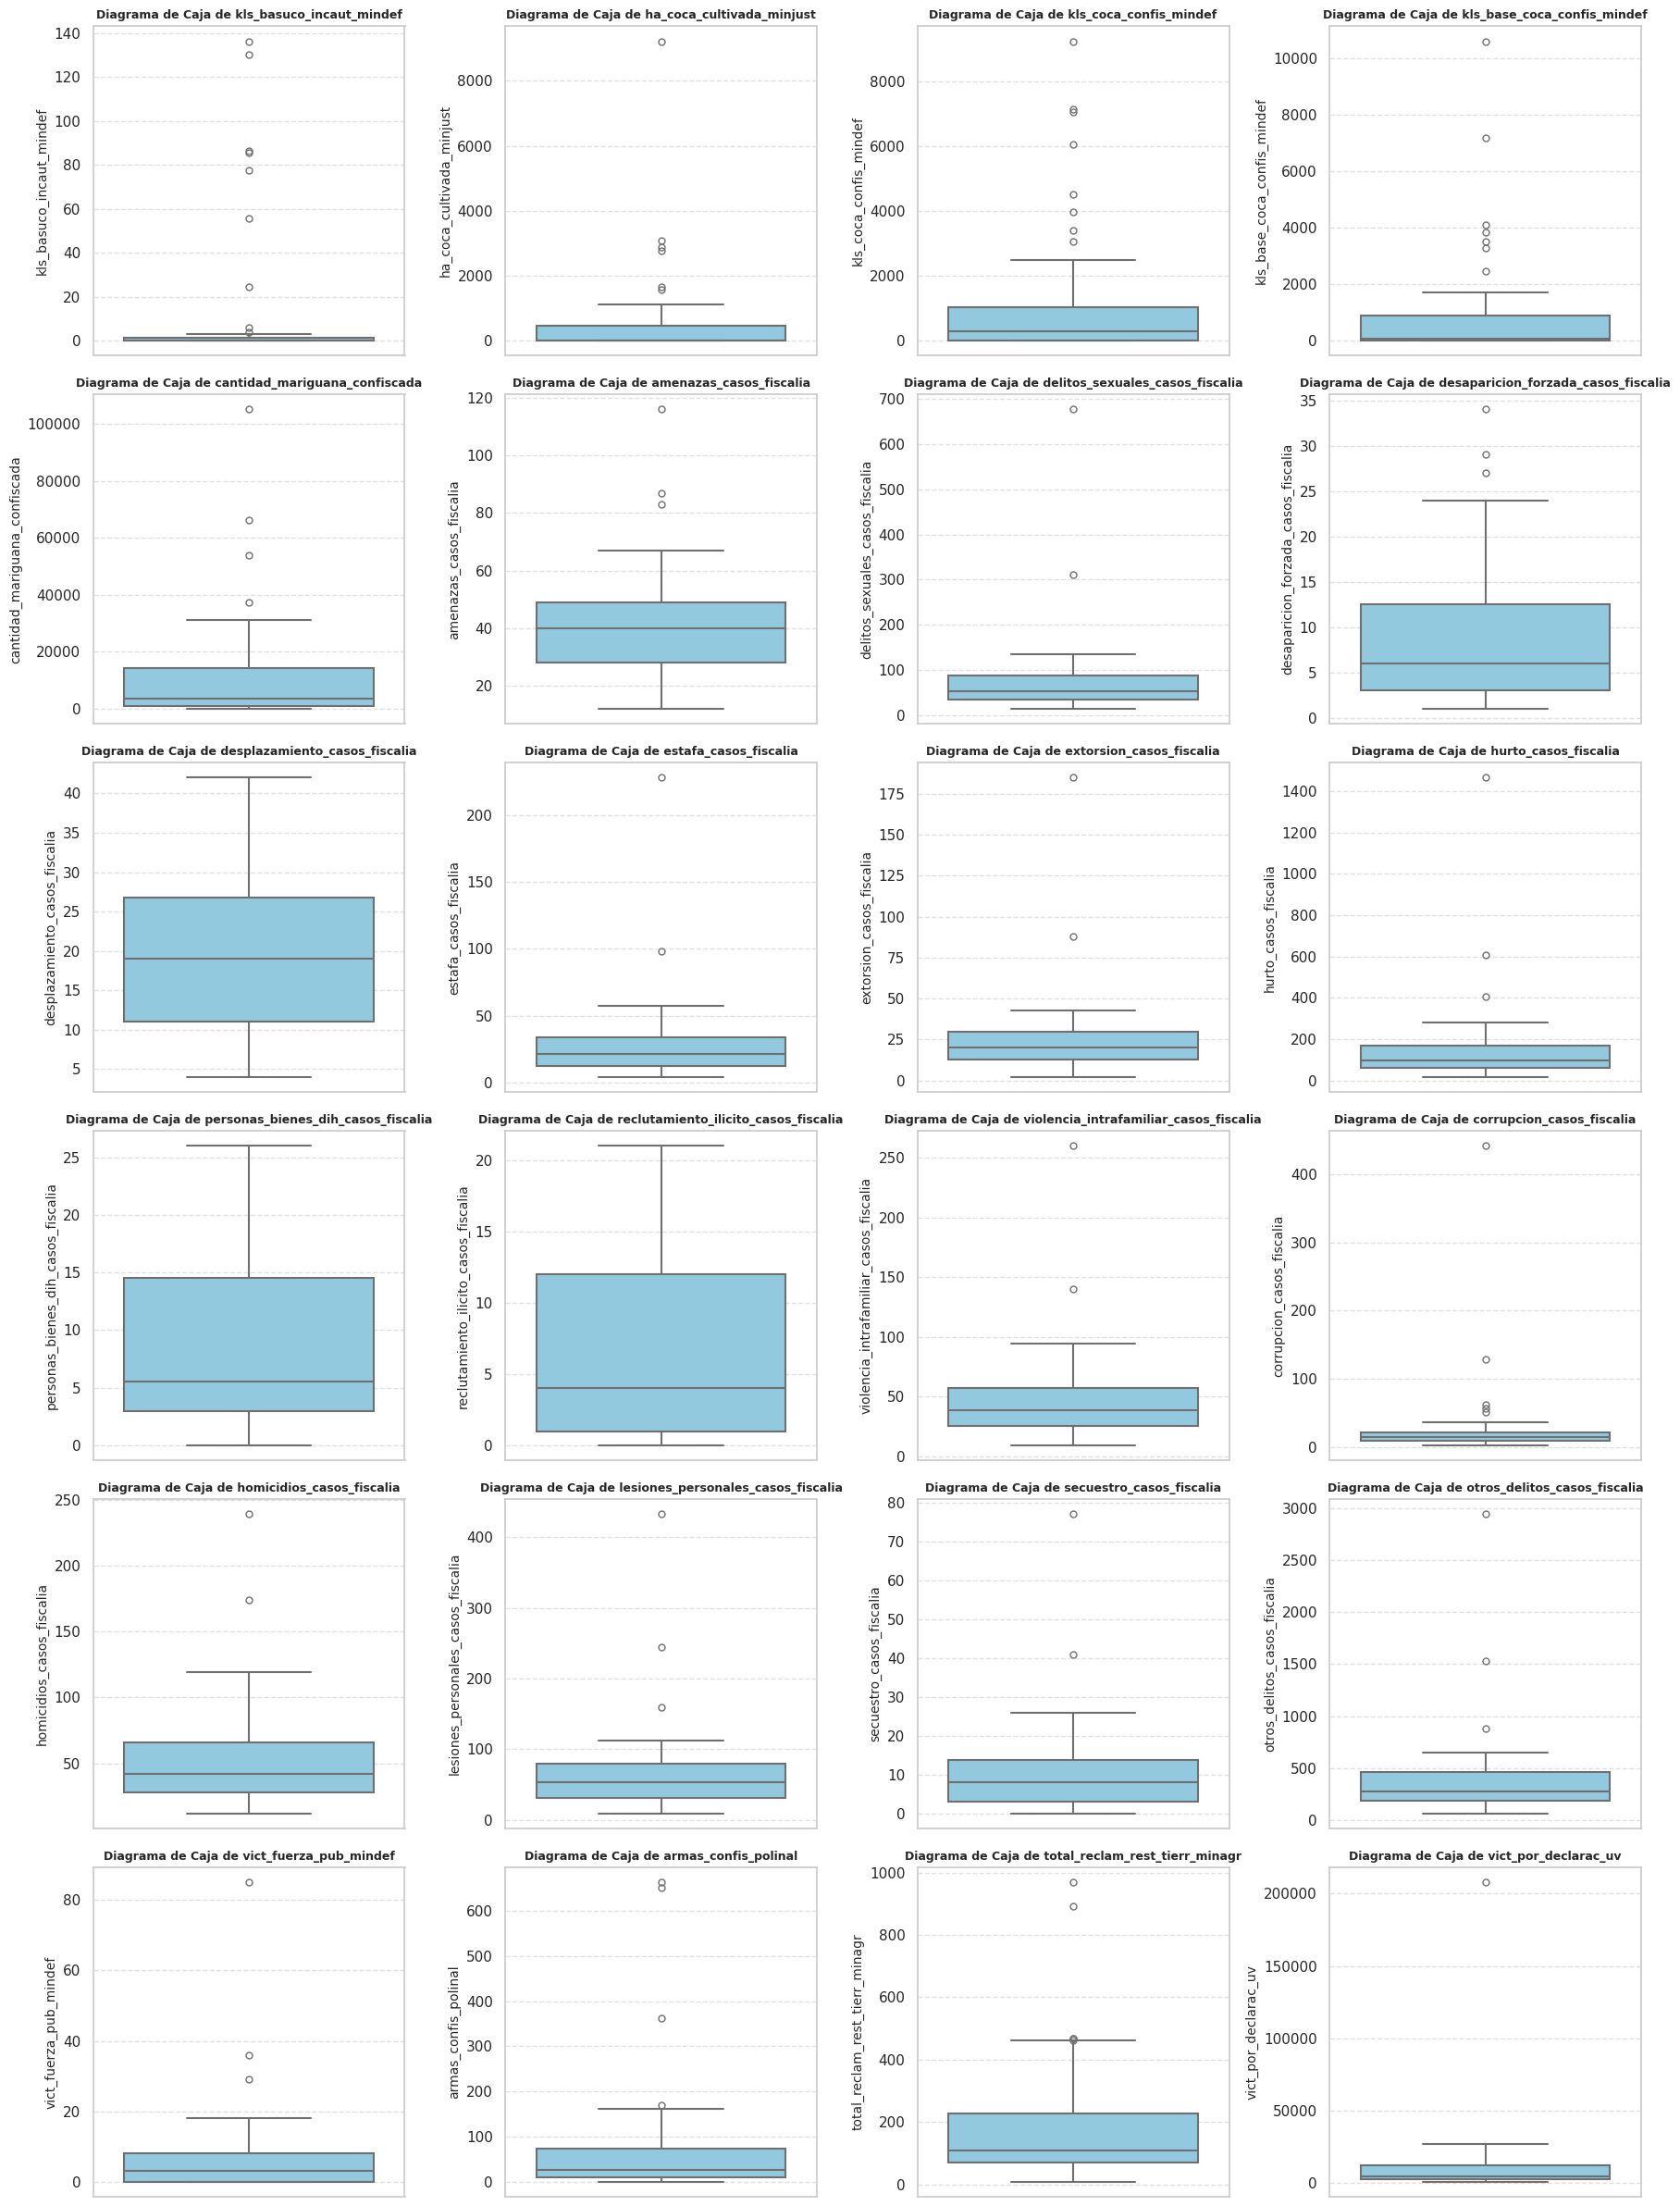

In [ ]:
# Uso:
plot_boxplots(df_var_violencia, var_violencia, save=True, filename='boxplot_var_violencia', format='png')

- Estudio de correlación entre variables socioeconómicas

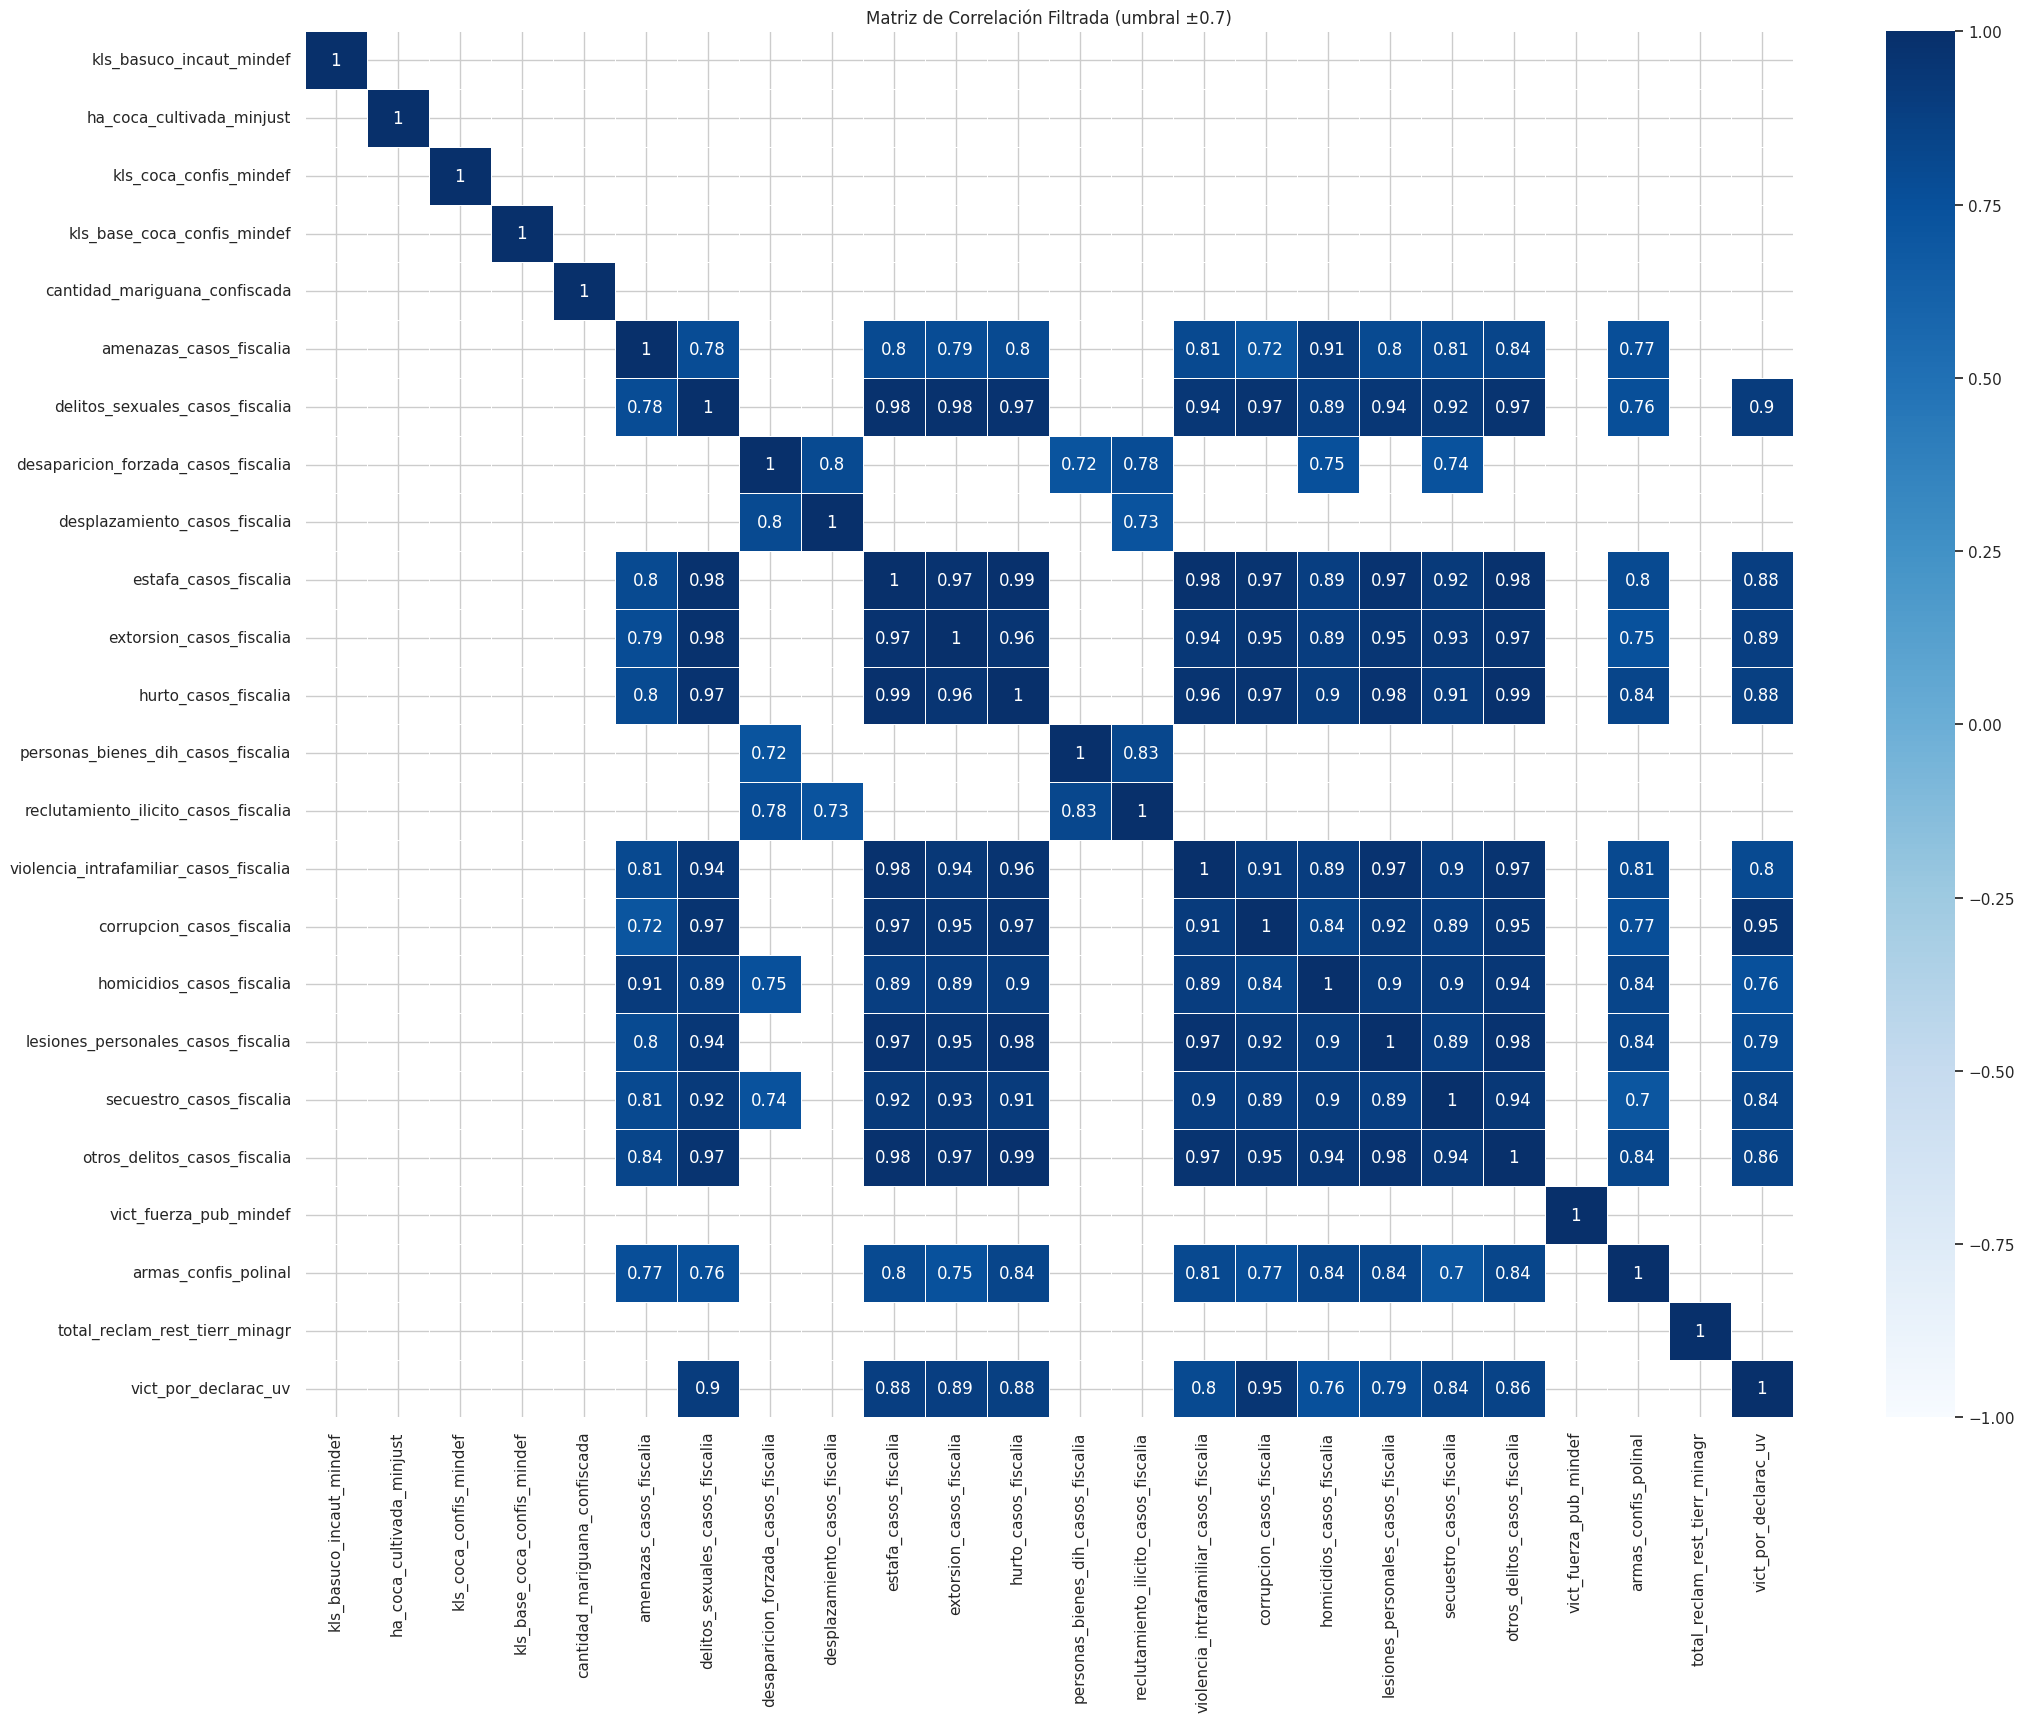

In [ ]:
# Extraer las columnas sobre violencia del dataset
df_violencia = df_var_violencia[var_violencia]

# Calcular la matriz de correlación usando el coeficiente de Pearson
matriz_correlacion = df_violencia.corr(method='pearson')

# Filtrar la matriz de correlación para mostrar solo aquellas correlaciones superiores a 0.7 o inferiores a -0.7
high_corr_mask = (matriz_correlacion >= 0.7) | (matriz_correlacion <= -0.7)
high_corr_matrix = matriz_correlacion.where(high_corr_mask)

# Crear un mapa de calor solo para las correlaciones altas
fig = plt.figure(figsize=(24, 18))
sns.heatmap(high_corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1, linewidths=0.5, mask=high_corr_matrix.isnull())

plt.title("Matriz de Correlación Filtrada (umbral ±0.7)")

plt.show()

# Guardar el gráfico en un archivo de imagen
save_plot(fig, 'matriz_correlacion_filtrada_violencia', format='png', dpi=300)

In [ ]:
# Convertir la matriz de correlación en un formato de tabla (long-form)
correlation_pairs = matriz_correlacion.stack().reset_index()
correlation_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Filtrar las correlaciones que sean mayores o iguales a 0.7 o menores o iguales a -0.7
high_corr_pairs = correlation_pairs[(correlation_pairs['Correlación'] >= 0.7) | (correlation_pairs['Correlación'] <= -0.7)]

# Excluir las correlaciones entre una variable y sí misma
high_corr_pairs = high_corr_pairs[high_corr_pairs['Variable 1'] != high_corr_pairs['Variable 2']]

# Eliminar duplicados (pares inversos)
high_corr_pairs = high_corr_pairs.drop_duplicates(subset=['Correlación'])

# Ordenar por la magnitud de la correlación
high_corr_pairs = high_corr_pairs.sort_values(by='Correlación', ascending=False)

# Mostrar el resultado en formato tabular
high_corr_pairs

Variable 1  \
227                estafa_casos_fiscalia   
283                 hurto_casos_fiscalia   
235                estafa_casos_fiscalia   
154      delitos_sexuales_casos_fiscalia   
153      delitos_sexuales_casos_fiscalia   
..                                   ...   
186  desaparicion_forzada_casos_fiscalia   
205        desplazamiento_casos_fiscalia   
180  desaparicion_forzada_casos_fiscalia   
135              amenazas_casos_fiscalia   
453             secuestro_casos_fiscalia   

                               Variable 2  Correlación  
227                  hurto_casos_fiscalia     0.986673  
283          otros_delitos_casos_fiscalia     0.985433  
235          otros_delitos_casos_fiscalia     0.983614  
154              extorsion_casos_fiscalia     0.979934  
153                 estafa_casos_fiscalia     0.977608  
..                                    ...          ...  
186              secuestro_casos_fiscalia     0.735923  
205  reclutamiento_ilicito_casos_fiscalia     0.731582  
180    personas_bienes_dih_casos_fiscalia     0.719335  
135             corrupcion_casos_fiscalia     0.717067  
453                  armas_confis_polinal     0.704202  

[83 rows x 3 columns]

In [ ]:
high_corr_matrix

kls_basuco_incaut_mindef  \
kls_basuco_incaut_mindef                                     1.0   
ha_coca_cultivada_minjust                                    NaN   
kls_coca_confis_mindef                                       NaN   
kls_base_coca_confis_mindef                                  NaN   
cantidad_mariguana_confiscada                                NaN   
amenazas_casos_fiscalia                                      NaN   
delitos_sexuales_casos_fiscalia                              NaN   
desaparicion_forzada_casos_fiscalia                          NaN   
desplazamiento_casos_fiscalia                                NaN   
estafa_casos_fiscalia                                        NaN   
extorsion_casos_fiscalia                                     NaN   
hurto_casos_fiscalia                                         NaN   
personas_bienes_dih_casos_fiscalia                           NaN   
reclutamiento_ilicito_casos_fiscalia                         NaN   
violencia_intrafamiliar_casos_fiscalia                       NaN   
corrupcion_casos_fiscalia                                    NaN   
homicidios_casos_fiscalia                                    NaN   
lesiones_personales_casos_fiscalia                           NaN   
secuestro_casos_fiscalia                                     NaN   
otros_delitos_casos_fiscalia                                 NaN   
vict_fuerza_pub_mindef                                       NaN   
armas_confis_polinal                                         NaN   
total_reclam_rest_tierr_minagr                               NaN   
vict_por_declarac_uv                                         NaN   

                                        ha_coca_cultivada_minjust  \
kls_basuco_incaut_mindef                                      NaN   
ha_coca_cultivada_minjust                                     1.0   
kls_coca_confis_mindef                                        NaN   
kls_base_coca_confis_mindef                                   NaN   
cantidad_mariguana_confiscada                                 NaN   
amenazas_casos_fiscalia                                       NaN   
delitos_sexuales_casos_fiscalia                               NaN   
desaparicion_forzada_casos_fiscalia                           NaN   
desplazamiento_casos_fiscalia                                 NaN   
estafa_casos_fiscalia                                         NaN   
extorsion_casos_fiscalia                                      NaN   
hurto_casos_fiscalia                                          NaN   
personas_bienes_dih_casos_fiscalia                            NaN   
reclutamiento_ilicito_casos_fiscalia                          NaN   
violencia_intrafamiliar_casos_fiscalia                        NaN   
corrupcion_casos_fiscalia                                     NaN   
homicidios_casos_fiscalia                                     NaN   
lesiones_personales_casos_fiscalia                            NaN   
secuestro_casos_fiscalia                                      NaN   
otros_delitos_casos_fiscalia                                  NaN   
vict_fuerza_pub_mindef                                        NaN   
armas_confis_polinal                                          NaN   
total_reclam_rest_tierr_minagr                                NaN   
vict_por_declarac_uv                                          NaN   

                                        kls_coca_confis_mindef  \
kls_basuco_incaut_mindef                                   NaN   
ha_coca_cultivada_minjust                                  NaN   
kls_coca_confis_mindef                                     1.0   
kls_base_coca_confis_mindef                                NaN   
cantidad_mariguana_confiscada                              NaN   
amenazas_casos_fiscalia                                    NaN   
delitos_sexuales_casos_fiscalia                            NaN   
desaparicion_forzada_casos_fiscalia                        NaN   
desplazamiento_caso

In [ ]:
df_var_violencia[['codigo_dane','kls_basuco_incaut_mindef', 'kls_coca_confis_mindef', 'kls_base_coca_confis_mindef','cantidad_mariguana_confiscada']].head()

codigo_dane  kls_basuco_incaut_mindef  kls_coca_confis_mindef  \
0        19001                   55.7841              3982.36223   
1        19022                    0.0000                 0.00000   
2        19050                    0.0000                 2.02600   
3        19075                    0.0000               550.03300   
4        19100                    0.0100               300.17800   

   kls_base_coca_confis_mindef  cantidad_mariguana_confiscada  
0                    238.46973                    17085.74363  
1                      0.00000                        0.04200  
2                      9.50000                        3.10000  
3                    706.77200                     1323.91300  
4                     76.67600                        2.16400

In [ ]:
df_var_violencia[['codigo_dane', 'amenazas_casos_fiscalia', 'extorsion_casos_fiscalia', 'secuestro_casos_fiscalia']].head()

codigo_dane  amenazas_casos_fiscalia  extorsion_casos_fiscalia  \
0        19001                      116                       185   
1        19022                       18                        12   
2        19050                       44                        18   
3        19075                       25                        23   
4        19100                       23                        18   

   secuestro_casos_fiscalia  
0                        77  
1                         1  
2                        10  
3                         8  
4                         4

In [ ]:
df_var_violencia[['codigo_dane', 'estafa_casos_fiscalia', 'hurto_casos_fiscalia', 'corrupcion_casos_fiscalia']].head()

codigo_dane  estafa_casos_fiscalia  hurto_casos_fiscalia  \
0        19001                    228                  1465   
1        19022                     10                    27   
2        19050                     19                    89   
3        19075                     21                    86   
4        19100                     23                    83   

   corrupcion_casos_fiscalia  
0                        441  
1                         16  
2                         15  
3                         21  
4                         16

In [ ]:
df_var_violencia[['codigo_dane', 'violencia_intrafamiliar_casos_fiscalia', 'homicidios_casos_fiscalia', 'lesiones_personales_casos_fiscalia','delitos_sexuales_casos_fiscalia']].head()

codigo_dane  violencia_intrafamiliar_casos_fiscalia  \
0        19001                                     260   
1        19022                                      25   
2        19050                                      29   
3        19075                                      46   
4        19100                                      44   

   homicidios_casos_fiscalia  lesiones_personales_casos_fiscalia  \
0                        239                                 433   
1                         26                                  18   
2                         70                                  45   
3                         40                                  56   
4                         39                                  76   

   delitos_sexuales_casos_fiscalia  
0                              677  
1                               30  
2                               86  
3                               49  
4                               62

- Acciones derivadas de analisis alta correlacion de variables

In [ ]:
# Crear los indicadores compuestos sumando las variables especificadas
df_var_violencia['indice_narcotrafico'] = df_var_violencia[['kls_basuco_incaut_mindef',
                                                            'kls_coca_confis_mindef',
                                                            'kls_base_coca_confis_mindef',
                                                            'cantidad_mariguana_confiscada']].sum(axis=1)

df_var_violencia['indice_coaccion_extorsion'] = df_var_violencia[['amenazas_casos_fiscalia',
                                                                  'extorsion_casos_fiscalia',
                                                                  'secuestro_casos_fiscalia']].sum(axis=1)

df_var_violencia['indice_delitos_economicos'] = df_var_violencia[['estafa_casos_fiscalia',
                                                                  'hurto_casos_fiscalia',
                                                                  'corrupcion_casos_fiscalia']].sum(axis=1)

df_var_violencia['indice_violencia_interpersonal'] = df_var_violencia[['violencia_intrafamiliar_casos_fiscalia',
                                                                      'homicidios_casos_fiscalia',
                                                                      'lesiones_personales_casos_fiscalia',
                                                                      'delitos_sexuales_casos_fiscalia']].sum(axis=1)

# Eliminar las variables relacionadas con afectación por conflicto armado, excepto las mencionadas
variables_conflicto_eliminar = [
    'desaparicion_forzada_casos_fiscalia',
    'desplazamiento_casos_fiscalia',
    'personas_bienes_dih_casos_fiscalia',
    'reclutamiento_ilicito_casos_fiscalia'
]
df_var_violencia.drop(columns=variables_conflicto_eliminar, inplace=True)

# Mantener variables por separado sin fusionarlas en un índice
variables_separadas = [
    'total_reclam_rest_tierr_minagr',
    'vict_por_declarac_uv',
    'otros_delitos_casos_fiscalia',
    'armas_confis_polinal',
    'ha_coca_cultivada_minjust',
    'vict_fuerza_pub_mindef'
]
# Opcional: Verificar si existen duplicados o inconsistencias en estas variables
df_var_violencia = df_var_violencia[variables_separadas + ['indice_narcotrafico', 'indice_coaccion_extorsion',
                                                           'indice_delitos_economicos', 'indice_violencia_interpersonal','codigo_dane']]

In [ ]:
df_var_violencia.head()

total_reclam_rest_tierr_minagr  vict_por_declarac_uv  \
0                             468              207858.0   
1                             107                3659.0   
2                             461               24584.0   
3                             165                7020.0   
4                             299                2839.0   

   otros_delitos_casos_fiscalia  armas_confis_polinal  \
0                          2943                 652.0   
1                           135                   3.0   
2                           287                  41.0   
3                           278                  27.0   
4                           273                  21.0   

   ha_coca_cultivada_minjust  vict_fuerza_pub_mindef  indice_narcotrafico  \
0                        0.0                    17.0          21362.35969   
1                        0.0                     1.0              0.04200   
2                     3085.0                    85.0             14.62600   
3                      499.0                    11.0           2580.71800   
4                       78.0                     3.0            379.02800   

   indice_coaccion_extorsion  indice_delitos_economicos  \
0                        378                       2134   
1                         31                         53   
2                         72                        123   
3                         56                        128   
4                         45                        122   

   indice_violencia_interpersonal  codigo_dane  
0                            1609        19001  
1                              99        19022  
2                             230        19050  
3                             191        19075  
4                             221        19100

In [ ]:
# Actualizar la lista var_violencia
# Eliminar variables que ya fueron fusionadas en indicadores o eliminadas
variables_fusionadas_o_eliminadas = [
    'kls_basuco_incaut_mindef', 'kls_coca_confis_mindef', 'kls_base_coca_confis_mindef',
    'cantidad_mariguana_confiscada', 'amenazas_casos_fiscalia', 'extorsion_casos_fiscalia',
    'secuestro_casos_fiscalia', 'estafa_casos_fiscalia', 'hurto_casos_fiscalia',
    'corrupcion_casos_fiscalia', 'violencia_intrafamiliar_casos_fiscalia',
    'homicidios_casos_fiscalia', 'lesiones_personales_casos_fiscalia',
    'delitos_sexuales_casos_fiscalia', 'desaparicion_forzada_casos_fiscalia',
    'desplazamiento_casos_fiscalia', 'personas_bienes_dih_casos_fiscalia',
    'reclutamiento_ilicito_casos_fiscalia'
]

# Eliminar las variables fusionadas o eliminadas de var_violencia
var_violencia = [var for var in var_violencia if var not in variables_fusionadas_o_eliminadas]


In [ ]:
# Variables nuevas
new_vars = ['indice_narcotrafico', 'indice_coaccion_extorsion', 'indice_delitos_economicos', 'indice_violencia_interpersonal']
var_violencia = var_violencia + new_vars

In [ ]:
df_var_violencia.head()

total_reclam_rest_tierr_minagr  vict_por_declarac_uv  \
0                             468              207858.0   
1                             107                3659.0   
2                             461               24584.0   
3                             165                7020.0   
4                             299                2839.0   

   otros_delitos_casos_fiscalia  armas_confis_polinal  \
0                          2943                 652.0   
1                           135                   3.0   
2                           287                  41.0   
3                           278                  27.0   
4                           273                  21.0   

   ha_coca_cultivada_minjust  vict_fuerza_pub_mindef  indice_narcotrafico  \
0                        0.0                    17.0          21362.35969   
1                        0.0                     1.0              0.04200   
2                     3085.0                    85.0             14.62600   
3                      499.0                    11.0           2580.71800   
4                       78.0                     3.0            379.02800   

   indice_coaccion_extorsion  indice_delitos_economicos  \
0                        378                       2134   
1                         31                         53   
2                         72                        123   
3                         56                        128   
4                         45                        122   

   indice_violencia_interpersonal  codigo_dane  
0                            1609        19001  
1                              99        19022  
2                             230        19050  
3                             191        19075  
4                             221        19100

In [ ]:
for i, name in enumerate(var_violencia):
  print(f'indice {i}:  {name}')

indice 0:  ha_coca_cultivada_minjust
indice 1:  otros_delitos_casos_fiscalia
indice 2:  vict_fuerza_pub_mindef
indice 3:  armas_confis_polinal
indice 4:  total_reclam_rest_tierr_minagr
indice 5:  vict_por_declarac_uv
indice 6:  indice_narcotrafico
indice 7:  indice_coaccion_extorsion
indice 8:  indice_delitos_economicos
indice 9:  indice_violencia_interpersonal


-  identificar la multicolinealidad entre las variables sobre la violencia que quedan con VIF - Factor de Inflación de la Varianza

In [ ]:
# Instalacion de bibliotecas para VIF
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Aplicar VIF
# Extraer solo las columnas socioeconómicas
X = df_var_violencia[var_violencia]

# Añadir una constante al modelo
X = sm.add_constant(X)

# Calcular el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Eliminar la fila correspondiente a la constante
vif_data = vif_data[vif_data["Variable"] != "const"]

# Ordenar el VIF de mayor a menor
vif_data = vif_data.sort_values(by="VIF", ascending=False)

# Mostrar el VIF para cada variable
print(vif_data)

                          Variable         VIF
9        indice_delitos_economicos  174.226482
2     otros_delitos_casos_fiscalia  113.413677
10  indice_violencia_interpersonal  103.383956
8        indice_coaccion_extorsion   30.544057
6             vict_por_declarac_uv   12.310729
4             armas_confis_polinal    4.686906
1        ha_coca_cultivada_minjust    2.127569
7              indice_narcotrafico    2.000379
5   total_reclam_rest_tierr_minagr    1.886667
3           vict_fuerza_pub_mindef    1.476728


- Implementar decisiones con base en valores VIF:

Creación de un índice de criminalidad general que fusione las variables “otros_delitos_casos_fiscalia”, “indice_coaccion_extorsion”, “indice_delitos_economicos” e “indice_violencia_interpersonal”, reflejando de manera robusta las diferentes dimensiones de la criminalidad sin duplicación informativa.

In [ ]:
# Definir las variables a fusionar en el Índice de Criminalidad General
variables_a_fusionar = ["otros_delitos_casos_fiscalia", "indice_coaccion_extorsion",
                        "indice_delitos_economicos", "indice_violencia_interpersonal"]

# Crear el Índice de Criminalidad General sumando los valores de las variables especificadas
df_var_violencia["indice_criminalidad_general"] = df_var_violencia[variables_a_fusionar].sum(axis=1)

# Actualizar la lista de variables de violencia, eliminando las fusionadas e incluyendo el nuevo índice
var_violencia = [var for var in var_violencia if var not in variables_a_fusionar]
var_violencia.append("indice_criminalidad_general")

# Borrar variables del df
df_var_violencia.drop(variables_a_fusionar, axis=1, inplace=True)

# Resultado
print("Lista actualizada de variables de violencia:", var_violencia)
df_var_violencia.head()

Lista actualizada de variables de violencia: ['ha_coca_cultivada_minjust', 'vict_fuerza_pub_mindef', 'armas_confis_polinal', 'total_reclam_rest_tierr_minagr', 'vict_por_declarac_uv', 'indice_narcotrafico', 'indice_criminalidad_general']


total_reclam_rest_tierr_minagr  vict_por_declarac_uv  armas_confis_polinal  \
0                             468              207858.0                 652.0   
1                             107                3659.0                   3.0   
2                             461               24584.0                  41.0   
3                             165                7020.0                  27.0   
4                             299                2839.0                  21.0   

   ha_coca_cultivada_minjust  vict_fuerza_pub_mindef  indice_narcotrafico  \
0                        0.0                    17.0          21362.35969   
1                        0.0                     1.0              0.04200   
2                     3085.0                    85.0             14.62600   
3                      499.0                    11.0           2580.71800   
4                       78.0                     3.0            379.02800   

   codigo_dane  indice_criminalidad_general  
0        19001                         7064  
1        19022                          318  
2        19050                          712  
3        19075                          653  
4        19100                          661

In [ ]:
df_var_violencia.shape

(42, 8)

In [ ]:
# Aplicar VIF
# Extraer solo las columnas socioeconómicas
X = df_var_violencia[var_violencia]

# Añadir una constante al modelo
X = sm.add_constant(X)

# Calcular el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Eliminar la fila correspondiente a la constante
vif_data = vif_data[vif_data["Variable"] != "const"]

# Ordenar el VIF de mayor a menor
vif_data = vif_data.sort_values(by="VIF", ascending=False)

# Mostrar el VIF para cada variable
print(vif_data)

                         Variable        VIF
7     indice_criminalidad_general  12.680041
5            vict_por_declarac_uv   5.624048
3            armas_confis_polinal   4.219029
4  total_reclam_rest_tierr_minagr   1.825622
1       ha_coca_cultivada_minjust   1.671117
6             indice_narcotrafico   1.316026
2          vict_fuerza_pub_mindef   1.190009


- Aplicar informacion mutua

In [ ]:
# Definir las variables de violencia
X = df_var_violencia[var_violencia]

# Calcular la información mutua entre las variables
mi_matrix = pd.DataFrame(np.zeros((X.shape[1], X.shape[1])), columns=var_violencia, index=var_violencia)

# Calcular la información mutua entre pares de variables
for i in range(X.shape[1]):
    for j in range(X.shape[1]):
        if i != j:
            # Información mutua entre la variable i y la j
            mi_matrix.iloc[i, j] = mutual_info_regression(X.iloc[:, [i]], X.iloc[:, j])[0]

# Mostrar la matriz abreviada
mi_matrix

ha_coca_cultivada_minjust  \
ha_coca_cultivada_minjust                        0.000000   
vict_fuerza_pub_mindef                           0.018179   
armas_confis_polinal                             0.081441   
total_reclam_rest_tierr_minagr                   0.050033   
vict_por_declarac_uv                             0.135655   
indice_narcotrafico                              0.080842   
indice_criminalidad_general                      0.039673   

                                vict_fuerza_pub_mindef  armas_confis_polinal  \
ha_coca_cultivada_minjust                     0.016688              0.088512   
vict_fuerza_pub_mindef                        0.000000              0.000000   
armas_confis_polinal                          0.017370              0.000000   
total_reclam_rest_tierr_minagr                0.001104              0.000000   
vict_por_declarac_uv                          0.212151              0.047116   
indice_narcotrafico                           0.000000              0.000000   
indice_criminalidad_general                   0.032578              0.320938   

                                total_reclam_rest_tierr_minagr  \
ha_coca_cultivada_minjust                             0.067890   
vict_fuerza_pub_mindef                                0.000000   
armas_confis_polinal                                  0.000000   
total_reclam_rest_tierr_minagr                        0.000000   
vict_por_declarac_uv                                  0.000000   
indice_narcotrafico                                   0.126909   
indice_criminalidad_general                           0.027759   

                                vict_por_declarac_uv  indice_narcotrafico  \
ha_coca_cultivada_minjust                   0.140627             0.073482   
vict_fuerza_pub_mindef                      0.217718             0.000000   
armas_confis_polinal                        0.046655             0.000000   
total_reclam_rest_tierr_minagr              0.000000             0.129073   
vict_por_declarac_uv                        0.000000             0.063903   
indice_narcotrafico                         0.061918             0.000000   
indice_criminalidad_general                 0.207961             0.104622   

                                indice_criminalidad_general  
ha_coca_cultivada_minjust                          0.050571  
vict_fuerza_pub_mindef                             0.061812  
armas_confis_polinal                               0.325887  
total_reclam_rest_tierr_minagr                     0.030224  
vict_por_declarac_uv                               0.207961  
indice_narcotrafico                                0.104622  
indice_criminalidad_general                        0.000000

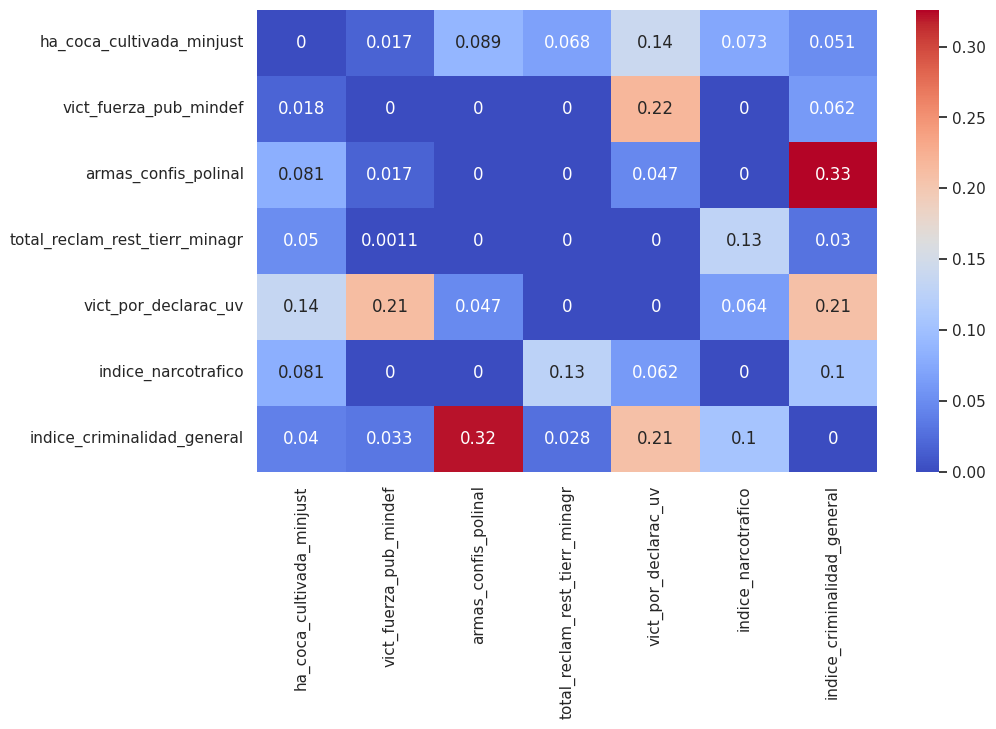

In [ ]:
# Crear un mapa de calor
# Abreviar los nombres de las columnas a los primeros 10 caracteres
column_names = [col for col in mi_matrix.columns]

plt.figure(figsize=(10, 6))
sns.heatmap(mi_matrix, annot=True, cmap='coolwarm')

# Personalizar el gráfico (opcional)
#plt.title('Mapa de Calor de Información Mutua')
#plt.xlabel('Variable')
#plt.ylabel('Variable')

# Mostrar el gráfico
plt.show()

### Normalizar las variables de violencia por la población de los municipios

Dado que las variables de violencia en el dataset son valores de conteo agregados a nivel de municipio, surge un tema importante: municipios con mayor población pueden mostrar recuentos de eventos violentos más altos simplemente porque tienen más habitantes y, en consecuencia, una mayor probabilidad de ocurrencia de dichos eventos. Este efecto podría crear sesgos, haciendo que los municipios más poblados se detecten como anómalos en el análisis sin necesariamente reflejar un mayor nivel de violencia proporcional a su tamaño.

Sino se normalizan las variables de violencia por la población, los municipios grandes tienden a aparecer más violentos en términos absolutos, aunque su nivel de violencia relativa pueda ser similar al de municipios más pequeños. Para abordar este posible sesgo, sería prudente realizar una normalización de las variables de violencia para reducir la influencia del tamaño poblacional. Por lo tanto se procede a dividir cada variable de conteo por la población del municipio y convertirlas en tasas por cada 10,000 habitantes

In [ ]:
# Lista de variables de violencia a normalizar
variables_a_normalizar = [
    'armas_confis_polinal',
    'indice_criminalidad_general',
    'indice_narcotrafico',
    'total_reclam_rest_tierr_minagr',
    'vict_fuerza_pub_mindef',
    'vict_por_declarac_uv'
]

# Unir datasets para acceder a la columna de población en df_var_violencia
df_var_violencia = df_var_violencia.merge(df_var_socieconomicas[['codigo_dane', 'poblacion']],
                                          on='codigo_dane', how='left')

# Normalizar dividiendo por la población y multiplicando por 10,000
for variable in variables_a_normalizar:
    df_var_violencia[f'{variable}_tasa'] = (df_var_violencia[variable] / df_var_violencia['poblacion']) * 10000

# Actualizar lista de variables de violencia normalizadas
var_violencia = [f'{variable}_tasa' for variable in variables_a_normalizar]

# Mover ha_coca_cultivada_minjust a var_socieconomicas
var_socieconomicas.append('ha_coca_cultivada_minjust')

In [ ]:
df_var_violencia[var_violencia].head(3)

armas_confis_polinal_tasa  indice_criminalidad_general_tasa  \
0                  19.207315                        208.098888   
1                   1.542416                        163.496144   
2                  14.736010                        255.903389   

   indice_narcotrafico_tasa  total_reclam_rest_tierr_minagr_tasa  \
0                629.315303                            13.786846   
1                  0.021594                            55.012853   
2                  5.256802                           165.690256   

   vict_fuerza_pub_mindef_tasa  vict_por_declarac_uv_tasa  
0                     0.500804                6123.303894  
1                     0.514139                1881.233933  
2                    30.550264                8835.855228

In [ ]:
df_var_violencia[['armas_confis_polinal','indice_criminalidad_general','indice_narcotrafico','total_reclam_rest_tierr_minagr']].head(3)

armas_confis_polinal  indice_criminalidad_general  indice_narcotrafico  \
0                 652.0                         7064          21362.35969   
1                   3.0                          318              0.04200   
2                  41.0                          712             14.62600   

   total_reclam_rest_tierr_minagr  
0                             468  
1                             107  
2                             461

In [ ]:
var_violencia

['armas_confis_polinal_tasa',
 'indice_criminalidad_general_tasa',
 'indice_narcotrafico_tasa',
 'total_reclam_rest_tierr_minagr_tasa',
 'vict_fuerza_pub_mindef_tasa',
 'vict_por_declarac_uv_tasa']

In [ ]:
var_socieconomicas

['poblacion',
 'ha_under_illegal_explotation',
 'ha_condicionada_upra',
 'ha_no_condicionada_upra',
 'desempleo_cens_2018',
 'tasa_alfab_cens_2018',
 'porc_est_1_cens_2018',
 'porc_est_2_cens_2018',
 'cobertura_neta_mined',
 'desercion_mined',
 'aprobacion_mined',
 'tasa_mort_general_minsal',
 'tasa_mort_ninez_minsal',
 'porc_bajo_peso_nacer_minsal',
 'per_ipm_sisben',
 'per_haci_critico_sisben',
 'viviendas_sisbenizados',
 'atencion_inf_prescolar',
 'tasa_afiliacion_salud',
 'indice_condiciones_vivienda',
 'ha_coca_cultivada_minjust']

### Visualizar en mapas las variables que quedaron

In [ ]:
# copiar columnas de datos geograficos a dataset de hechos de violencia
# Realizar la fusión manteniendo solo las columnas requeridas
df_var_violencia = df_var_violencia.merge(
    df_var_socieconomicas[['codigo_dane', 'geometria_mpio', 'geometria_cabecera', 'nombre_municipio']],
    on='codigo_dane',
    how='left',
    suffixes=('', '_socieconomicas')
)

# Eliminar las columnas duplicadas si quedaron
df_var_violencia = df_var_violencia.loc[:, ~df_var_violencia.columns.str.endswith('_socieconomicas')]

In [ ]:
# Convertir a un GeoDataFrame
geo_violencia = gpd.GeoDataFrame(df_var_violencia, geometry=gpd.GeoSeries.from_wkb(df_var_violencia['geometria_mpio']))

In [ ]:
# Convertir las cabeceras municipales en geometrías de puntos
geo_violencia['geometria_cabecera'] = gpd.GeoSeries.from_wkb(geo_violencia['geometria_cabecera'])

In [ ]:
#Definir el sistema de referencia de coordenadas (CRS)
geo_violencia = geo_violencia.set_crs(epsg=4326, inplace=True)

In [ ]:
geo_violencia.columns

Index(['total_reclam_rest_tierr_minagr', 'vict_por_declarac_uv',
       'armas_confis_polinal', 'ha_coca_cultivada_minjust',
       'vict_fuerza_pub_mindef', 'indice_narcotrafico', 'codigo_dane',
       'indice_criminalidad_general', 'poblacion', 'armas_confis_polinal_tasa',
       'indice_criminalidad_general_tasa', 'indice_narcotrafico_tasa',
       'total_reclam_rest_tierr_minagr_tasa', 'vict_fuerza_pub_mindef_tasa',
       'vict_por_declarac_uv_tasa', 'geometria_mpio', 'geometria_cabecera',
       'nombre_municipio', 'geometry'],
      dtype='object')

In [ ]:
# Uso de la funcion parra crear los mapas
fig, ax = plot_variable(geo_violencia, 'vict_por_declarac_uv_tasa')
if fig:
    save_plot(fig, "map_vio_vict_por_declarac_uv_tasa")

In [ ]:
df_var_violencia.columns

Index(['total_reclam_rest_tierr_minagr', 'vict_por_declarac_uv',
       'armas_confis_polinal', 'ha_coca_cultivada_minjust',
       'vict_fuerza_pub_mindef', 'indice_narcotrafico', 'codigo_dane',
       'indice_criminalidad_general', 'poblacion', 'armas_confis_polinal_tasa',
       'indice_criminalidad_general_tasa', 'indice_narcotrafico_tasa',
       'total_reclam_rest_tierr_minagr_tasa', 'vict_fuerza_pub_mindef_tasa',
       'vict_por_declarac_uv_tasa', 'geometria_mpio', 'geometria_cabecera',
       'nombre_municipio'],
      dtype='object')

- Dataset finales depurados

In [ ]:
df_socieconomico_final = df_var_socieconomicas[[*var_socieconomicas, 'codigo_dane', 'geometria_mpio', 'geometria_cabecera', 'nombre_municipio']]
df_violencia_final = df_var_violencia[[*var_violencia, 'codigo_dane', 'geometria_mpio', 'geometria_cabecera', 'nombre_municipio']]

In [ ]:
df_socieconomico_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 4 to 209
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   poblacion                     42 non-null     float64
 1   ha_under_illegal_explotation  42 non-null     float64
 2   ha_condicionada_upra          42 non-null     float64
 3   ha_no_condicionada_upra       42 non-null     float64
 4   desempleo_cens_2018           42 non-null     float64
 5   tasa_alfab_cens_2018          42 non-null     float64
 6   porc_est_1_cens_2018          42 non-null     float64
 7   porc_est_2_cens_2018          42 non-null     float64
 8   cobertura_neta_mined          42 non-null     float64
 9   desercion_mined               42 non-null     float64
 10  aprobacion_mined              42 non-null     float64
 11  tasa_mort_general_minsal      42 non-null     float64
 12  tasa_mort_ninez_minsal        42 non-null     float64
 13  porc_bajo_p

In [ ]:
df_violencia_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   armas_confis_polinal_tasa            42 non-null     float64
 1   indice_criminalidad_general_tasa     42 non-null     float64
 2   indice_narcotrafico_tasa             42 non-null     float64
 3   total_reclam_rest_tierr_minagr_tasa  42 non-null     float64
 4   vict_fuerza_pub_mindef_tasa          42 non-null     float64
 5   vict_por_declarac_uv_tasa            42 non-null     float64
 6   codigo_dane                          42 non-null     int64  
 7   geometria_mpio                       42 non-null     object 
 8   geometria_cabecera                   42 non-null     object 
 9   nombre_municipio                     42 non-null     object 
dtypes: float64(6), int64(1), object(3)
memory usage: 3.4+ KB


In [ ]:
# Especificar las rutas en Google Drive donde deseas guardar los archivos
ruta_socieconomico = '/content/drive/MyDrive/analytics_data_proyect/CSV_finales/df_socieconomico_final.csv'
ruta_violencia = '/content/drive/MyDrive/analytics_data_proyect/CSV_finales/df_violencia_final.csv'

# Guardar los DataFrames como archivos CSV
df_socieconomico_final.to_csv(ruta_socieconomico, index=False)
df_violencia_final.to_csv(ruta_violencia, index=False)

print("Los DataFrames se han guardado exitosamente en Google Drive.")

Los DataFrames se han guardado exitosamente en Google Drive.
